In [1]:
from datetime import datetime
start_time = datetime.now()

# Librairies

In [2]:
import numpy as np
import seaborn as sns
import requests
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.decomposition import PCA
from sklearn import set_config
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pandas_profiling import ProfileReport
pd.set_option('display.max_columns', None)
%matplotlib inline

# Read Data

In [3]:
# Original Dataset
df = pd.read_csv('./data/flights_train.csv.bz2')
df_sub = pd.read_csv('./data/flights_Xtest.csv.bz2')

In [4]:
df['flight_date'] = pd.to_datetime(df['flight_date'])
df_sub['flight_date'] = pd.to_datetime(df_sub['flight_date'])

# Utils

### APIs

In [5]:
""" the Metadata API"""

from joblib import Memory
location = './cachedir'
memory = Memory(location, verbose=0)

headers = {'x-rapidapi-host': "airport-info.p.rapidapi.com",
           'x-rapidapi-key': "670c14cef2mshc0f539c8f496dbcp19f4cejsn7e4b16db61a9"}

def metadata_airport(code):
    """
    we get meta data for each airport
    """
    url = "https://airport-info.p.rapidapi.com/airport"
    querystring = {"iata" : code, "icao" : code}
    response = requests.request("GET", url, headers=headers, params=querystring)
#     print(response.text)
    response = dict(eval(response.text))
    
    return pd.Series([response["latitude"], response["longitude"], response["country"], response["city"]])

metadata_airport = memory.cache(metadata_airport)

metadata_airport('CMN')

0    33.371754
1    -7.587027
2      Morocco
3     Nouaceur
dtype: object

the use of joblib librairie to accelerate the processe pf data collection also because of limited number of requests we can do on the API

In [6]:
# df['from_city'] = df['from'].apply(metadata_airport)
# df['to_city'] = df['to'].apply(metadata_airport)

In [7]:
# df_sub['from_city'] = df_sub['from'].apply(metadata_airport)
# df_sub['to_city'] = df_sub['to'].apply(metadata_airport)

In [8]:
# df[['from_latitude', 'from_longitude', 'from_country']] = df['from'].apply(metadata_airport)
# df[['to_latitude', 'to_longitude', 'to_country']] = df['to'].apply(metadata_airport)

In [9]:
# df_sub[['from_latitude', 'from_longitude', 'from_country']] = df_sub['from'].apply(metadata_airport)
# df_sub[['to_latitude', 'to_longitude', 'to_country']] = df_sub['to'].apply(metadata_airport)

In [10]:
""" Holydays API """
location = './cachedir'
memory = Memory(location, verbose=0)

headers = {
    'x-rapidapi-host': "public-holiday.p.rapidapi.com",
    'x-rapidapi-key': "670c14cef2mshc0f539c8f496dbcp19f4cejsn7e4b16db61a9"
    }

def get_holidays(year):
    
    url = "https://public-holiday.p.rapidapi.com/"+ str(year) + "/US"
    response = requests.request("GET", url, headers=headers)

    response = response.json()
    return response
    
get_holidays = memory.cache(get_holidays)

response_2011 = get_holidays(2011)
holidays_2011 = [response_2011[i]['date'] for i in range(len(response_2011))]

response_2012 = get_holidays(2012)
holidays_2012 = [response_2012[i]['date'] for i in range(len(response_2012))]

response_2013 = get_holidays(2013)
holidays_2013 = [response_2013[i]['date'] for i in range(len(response_2013))]

holidays = holidays_2011 + holidays_2012 + holidays_2013
print(holidays)

['2010-12-31', '2011-01-17', '2011-02-21', '2011-04-22', '2011-04-22', '2011-05-30', '2011-07-04', '2011-09-05', '2011-10-10', '2011-11-11', '2011-11-24', '2011-12-26', '2012-01-02', '2012-01-16', '2012-02-20', '2012-04-06', '2012-04-06', '2012-05-28', '2012-07-04', '2012-09-03', '2012-10-08', '2012-11-12', '2012-11-22', '2012-12-25', '2013-01-01', '2013-01-20', '2013-01-21', '2013-02-18', '2013-03-29', '2013-03-29', '2013-05-27', '2013-07-04', '2013-09-02', '2013-10-14', '2013-11-11', '2013-11-28', '2013-12-25']


### function that calculate the distance between cities

In [11]:
import geopy.distance
def calculate_distance(l1, L1, l2, L2):
    coords_1 = (l1, L1)
    coords_2 = (l2, L2)
    return geopy.distance.distance(coords_1, coords_2).km

### Blending Models

In [12]:
def blender(models):
    return np.mean(models, axis=0)

# Data descripton

In [13]:
df = df.set_index('flight_date')
df = df.sort_index()

In [14]:
df.head()

,from,to,avg_weeks,target,std_weeks
flight_date,,,,,
2011-09-01,DTW,ORD,9.055556,11.251560,6.053412
2011-09-01,ORD,DEN,12.000000,11.426462,8.129632
2011-09-01,EWR,BOS,11.350000,11.159896,8.330508
2011-09-01,SFO,DFW,11.454545,11.321779,7.920602
2011-09-01,DEN,LAX,12.607143,11.634324,8.288052


**In order to add new data, we can use the correlation with the target variable as the only cretarion**

<AxesSubplot:>

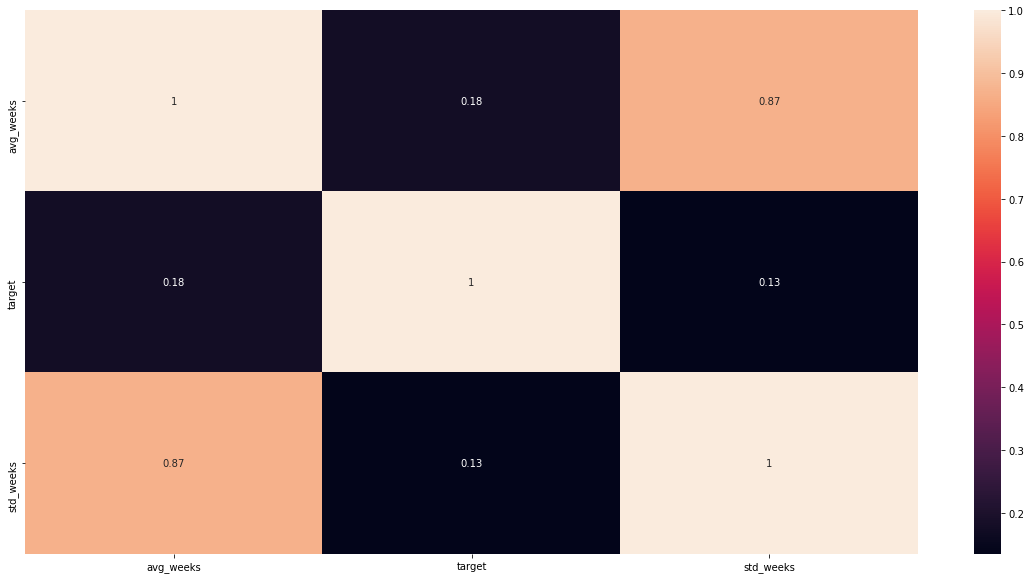

In [15]:
fig = plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True)

- target variable is symetric 
- there is no hard correlation between target and other dependent variable.

we need to add meta data, first thing add coordinate for each eaiport, to determine the distance between airports because the price of a flight ticket correlate with the distance, and costumers tend to not let go expensive flight tickets

**the new data is collected thanks to an api that get airports infos**

In [16]:
df = pd.read_csv('./data/train_with_coor.csv')
df_sub = pd.read_csv('./data/test_with_coor.csv')

In [17]:
df.head()

,flight_date,from,to,avg_weeks,target,std_weeks,from_latitude,from_longitude,from_country,to_latitude,to_longitude,to_country
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647,41.974163,-87.907320,United States,32.899810,-97.04034,United States
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734,36.084000,-115.153740,United States,39.856100,-104.67374,United States
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883,39.856100,-104.673740,United States,33.941590,-118.40853,United States
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202,33.640728,-84.427704,United States,41.974163,-87.90732,United States
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159,39.856100,-104.673740,United States,37.621310,-122.37895,United States


In [18]:
print("the unique values of the from country", df['from_country'].value_counts())
print("the unique values of the to country", df['to_country'].value_counts())

the unique values of the from country United States    8896
Name: from_country, dtype: int64
the unique values of the to country United States    8896
Name: to_country, dtype: int64


- All the flights from and to are domestic ones
- we should drop from_country and to_country because they have one unique value
- Also we are going to calculate the distance between cities using coordinates

In [19]:
df = df.drop(['from_country', 'to_country'], axis=1)
df_sub = df_sub.drop(['from_country', 'to_country'], axis=1)

In [20]:
# df['distance'] = np.vectorize(calculate_distance)(df['from_latitude'], df['from_longitude'], df['to_latitude'], df['to_longitude'])
# df_sub['distance'] = np.vectorize(calculate_distance)(df_sub['from_latitude'], df_sub['from_longitude'], df_sub['to_latitude'], df_sub['to_longitude'])

In order to save time while execution, we execute the code above one time and then we save the dataset to get a new data set

In [21]:
df = pd.read_csv('./data/train_with_city.csv', parse_dates=['flight_date'])
df_sub = pd.read_csv('./data/test_with_city.csv', parse_dates=['flight_date'])

In [22]:
df = df.drop(['from_city', 'to_city'], axis=1)
df_sub = df_sub.drop(['from_city', 'to_city'], axis=1)

<AxesSubplot:>

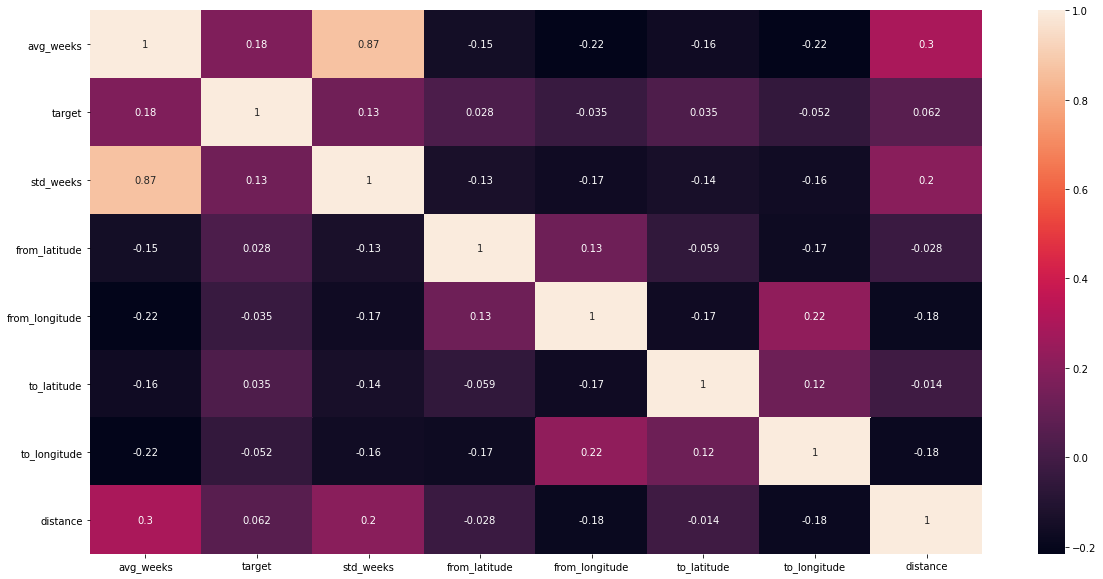

In [23]:
fig = plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True)

We can that the distance isnt a depepending variable that coralate well with the target variable.

In [24]:
df['year'] = pd.DatetimeIndex(df['flight_date']).year
df_sub['year'] = pd.DatetimeIndex(df_sub['flight_date']).year

df['month'] = pd.DatetimeIndex(df['flight_date']).month
df_sub['month'] = pd.DatetimeIndex(df_sub['flight_date']).month

df['day'] = pd.DatetimeIndex(df['flight_date']).day
df_sub['day'] = pd.DatetimeIndex(df_sub['flight_date']).day

df['quarter'] = pd.DatetimeIndex(df['flight_date']).quarter
df_sub['quarter'] = pd.DatetimeIndex(df_sub['flight_date']).quarter

df['dayofweek'] = pd.DatetimeIndex(df['flight_date']).dayofweek
df_sub['dayofweek'] = pd.DatetimeIndex(df_sub['flight_date']).dayofweek

df['week'] = df['flight_date'].dt.isocalendar().week.astype(int)
df_sub['week'] = df_sub['flight_date'].dt.isocalendar().week.astype(int)

In [25]:
df['julian'] = (df['flight_date'] - pd.to_datetime("2010-01-01")).dt.days
df_sub['julian'] = (df_sub['flight_date'] - pd.to_datetime("2010-01-01")).dt.days

- We spilt our 'flight_date' variable into three variables 'year', 'month' and 'day' also we add the 'week' and the 'dayofweek'
- we add a 'julian' variable: the number of days from '2000-01-01'

<AxesSubplot:>

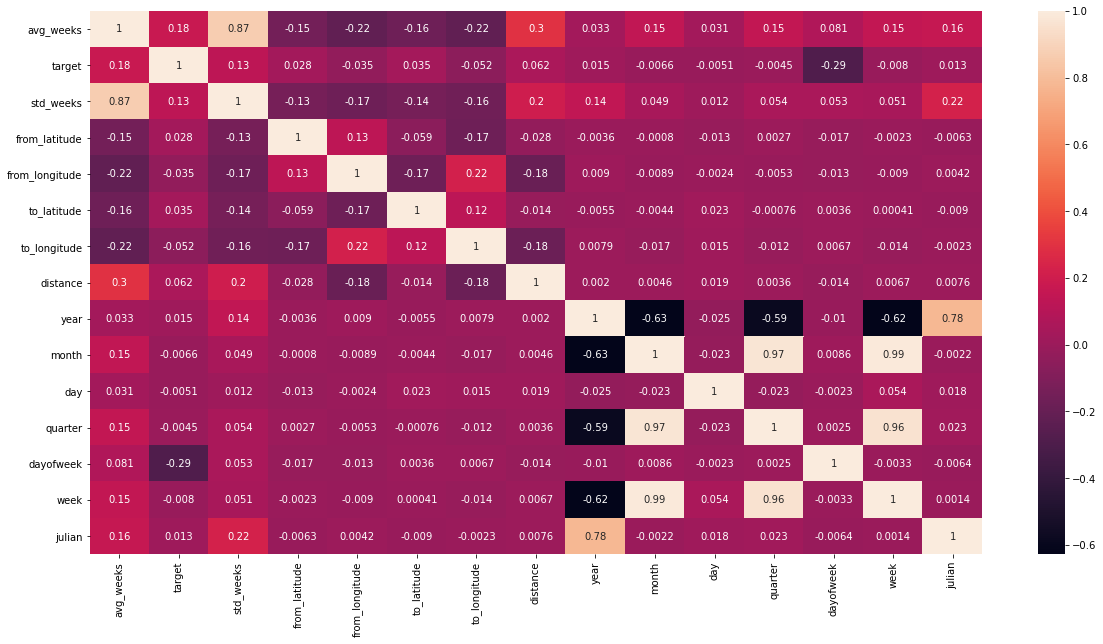

In [26]:
fig = plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True)

In [27]:
df

,flight_date,from,to,avg_weeks,target,std_weeks,from_latitude,from_longitude,to_latitude,to_longitude,distance,year,month,day,quarter,dayofweek,week,julian
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647,41.974163,-87.907320,32.899810,-97.040340,1289.698532,2012,6,19,2,1,25,900
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734,36.084000,-115.153740,39.856100,-104.673740,1010.700812,2012,9,10,3,0,37,983
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883,39.856100,-104.673740,33.941590,-118.408530,1386.808962,2012,10,5,4,4,40,1008
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202,33.640728,-84.427704,41.974163,-87.907320,974.145965,2011,10,9,4,6,40,646
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159,39.856100,-104.673740,37.621310,-122.378950,1556.562600,2012,2,21,1,1,8,781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,2011-11-24,DEN,PHX,11.045455,9.795363,7.791798,39.856100,-104.673740,33.437267,-112.007790,967.511116,2011,11,24,4,3,47,692
8892,2012-09-01,ATL,DEN,11.000000,9.429776,7.937254,33.640728,-84.427704,39.856100,-104.673740,1929.754252,2012,9,1,3,5,35,974
8893,2012-08-10,ORD,EWR,9.476190,12.029971,6.903760,41.974163,-87.907320,40.689533,-74.174460,1157.147451,2012,8,10,3,4,32,952
8894,2012-07-03,ORD,IAH,10.250000,9.381645,7.107261,41.974163,-87.907320,29.990220,-95.336784,1487.504532,2012,7,3,3,1,27,914


In [28]:
unique_iata = df['from'].unique()
unique_iata_sub = df['from'].unique()

In [29]:
# for iata in unique_iata:
#     df[iata] = 0

# for ind in range(df.shape[0]):
#     FROM = df['from'][ind]
#     TO = df['to'][ind]
#     df[FROM][ind] = 1
#     df[TO][ind] = 2

In [30]:
# for iata in unique_iata_sub:
#     df_sub[iata] = 0

# for ind in range(df_sub.shape[0]):
#     FROM = df_sub['from'][ind]
#     TO = df_sub['to'][ind]
#     df_sub[FROM][ind] = 1
#     df_sub[TO][ind] = 2

In [31]:
df.describe()

,avg_weeks,target,std_weeks,from_latitude,from_longitude,to_latitude,to_longitude,distance,year,month,day,quarter,dayofweek,week,julian
count,8896.000000,8896.000000,8896.000000,8896.000000,8896.000000,8896.000000,8896.000000,8896.000000,8896.000000,8896.00000,8896.000000,8896.000000,8896.000000,8896.000000,8896.000000
mean,11.580564,11.079129,8.648275,37.833930,-93.689316,37.729866,-93.592676,1722.118916,2011.715378,7.11893,15.549798,2.708521,2.979317,29.111286,826.623876
std,2.726443,0.949174,2.045742,4.660864,17.412678,4.717283,17.510755,1086.945980,0.451260,3.39818,8.859036,1.118860,2.001073,14.735326,128.275283
min,2.625000,5.586968,2.160247,25.795864,-122.378950,25.795864,-122.378950,296.970015,2011.000000,1.00000,1.000000,1.000000,0.000000,1.000000,608.000000
25%,9.722222,10.528622,7.216347,33.640728,-112.007790,33.640728,-112.007790,974.145965,2011.000000,4.00000,8.000000,2.000000,1.000000,16.000000,715.000000
50%,11.447222,11.063493,8.597628,39.856100,-87.907320,39.856100,-87.907320,1429.504256,2012.000000,8.00000,16.000000,3.000000,3.000000,33.000000,825.000000
75%,13.320000,11.630678,10.079555,41.974163,-80.287050,41.974163,-80.287050,2234.974856,2012.000000,10.00000,23.000000,4.000000,5.000000,42.000000,938.000000
max,22.372093,14.224277,14.958061,47.450250,-71.009560,47.450250,-71.009560,4351.692964,2012.000000,12.00000,31.000000,4.000000,6.000000,52.000000,1048.000000


- we add average flight price from the origine
- we add average flight price to the origine
- we calculate the difference between the two variables and save it in 'Fare' variable

**the data is collected from us Dasaset**

Average Fares are based on domestic itinerary fares. Fares are based on the total ticket value which consists of the price charged by the airlines plus any additional taxes and fees levied by an outside entity at the time of purchase.

link: https://www.bts.gov/air-fares

In [32]:
fare_2011 = pd.read_excel('./data/AverageFareAnnual2011_quarter.xlsx')
fare_2012 = pd.read_excel('./data/AverageFareAnnual2012_quarter.xlsx')
fare_2013 = pd.read_excel('./data/AverageFareAnnual2013_quarter.xlsx')

fare_2011['year'] = 2011
fare_2012['year'] = 2012
fare_2013['year'] = 2013

In [33]:
# lets concatenat the two datasets after we are going to merge if with the initial dataset
concatenated_data = pd.concat([fare_2011, fare_2012, fare_2013])
concatenated_data = concatenated_data.reset_index()
concatenated_data

,index,2020 Passenger Rank,Airport Code,City Name,State Name,Average Fare ($),Inflation Adjusted Average Fare ($) (Base Year: 2021),year,quarter
0,0,1,LAX,Los Angeles,CA,378.55,459.92,2011,1
1,1,2,ATL,Atlanta,GA,360.27,437.72,2011,1
2,2,3,DEN,Denver,CO,315.92,383.83,2011,1
3,3,4,ORD,Chicago-O'Hare,IL,388.95,472.56,2011,1
4,4,5,DFW,Dallas-DFW,TX,431.15,523.83,2011,1
...,...,...,...,...,...,...,...,...,...
5285,1753,413,SPB,Charlotte Amalie,VI,179.00,206.70,2013,4
5286,1754,413,SVC,Silver City/Hurley,NM,497.58,574.59,2013,4
5287,1755,413,VIS,Visalia,CA,380.46,439.34,2013,4
5288,1756,413,WRL,Worland,WY,588.50,679.58,2013,4


We merge the original dataset with this new dataset on 'from' and 'year' and then 'to' and 'year' on left join.

In [34]:
merged_df_1 = df.merge(concatenated_data, left_on=['from', 'quarter', 'year'], right_on=['Airport Code', 'quarter', 'year'], how='left')
merged_df_sub_1 = df_sub.merge(concatenated_data, left_on=['from', 'quarter', 'year'], right_on=['Airport Code', 'quarter', 'year'], how='left')

In [35]:
merged_df_2 = df.merge(concatenated_data, left_on=['to', 'quarter', 'year'], right_on=['Airport Code', 'quarter', 'year'], how='left')
merged_df_sub_2 = df_sub.merge(concatenated_data, left_on=['to', 'quarter', 'year'], right_on=['Airport Code', 'quarter', 'year'], how='left')

In [36]:
merged_df = merged_df_1.join(merged_df_2['Average Fare ($)'], rsuffix='_to')
merged_df_sub = merged_df_sub_1.join(merged_df_sub_2['Average Fare ($)'], rsuffix='_to')

Drop unnecessary columns 

In [37]:
merged_df = merged_df.drop(['index', 'Airport Code', 'City Name', 'State Name', '2020 Passenger Rank', 'Inflation Adjusted Average Fare ($) (Base Year: 2021)'], axis=1)
merged_df_sub = merged_df_sub.drop(['index', 'Airport Code', 'City Name', 'State Name', '2020 Passenger Rank', 'Inflation Adjusted Average Fare ($) (Base Year: 2021)'], axis=1)

In [38]:
# generate the 'Fare' column
merged_df['Fare'] = np.log(abs(merged_df['Average Fare ($)'] - merged_df['Average Fare ($)_to']) + 1)
merged_df_sub['Fare'] = np.log(abs(merged_df_sub['Average Fare ($)'] - merged_df_sub['Average Fare ($)_to']) + 1)

In [39]:
merged_df.head()

,flight_date,from,to,avg_weeks,target,std_weeks,from_latitude,from_longitude,to_latitude,to_longitude,distance,year,month,day,quarter,dayofweek,week,julian,Average Fare ($),Average Fare ($)_to,Fare
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647,41.974163,-87.907320,32.899810,-97.04034,1289.698532,2012,6,19,2,1,25,900,392.50,449.76,4.064916
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734,36.084000,-115.153740,39.856100,-104.67374,1010.700812,2012,9,10,3,0,37,983,261.84,315.72,4.005149
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883,39.856100,-104.673740,33.941590,-118.40853,1386.808962,2012,10,5,4,4,40,1008,320.95,409.82,4.498364
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202,33.640728,-84.427704,41.974163,-87.90732,974.145965,2011,10,9,4,6,40,646,378.08,373.97,1.631199
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159,39.856100,-104.673740,37.621310,-122.37895,1556.562600,2012,2,21,1,1,8,781,320.96,377.89,4.059235


<AxesSubplot:>

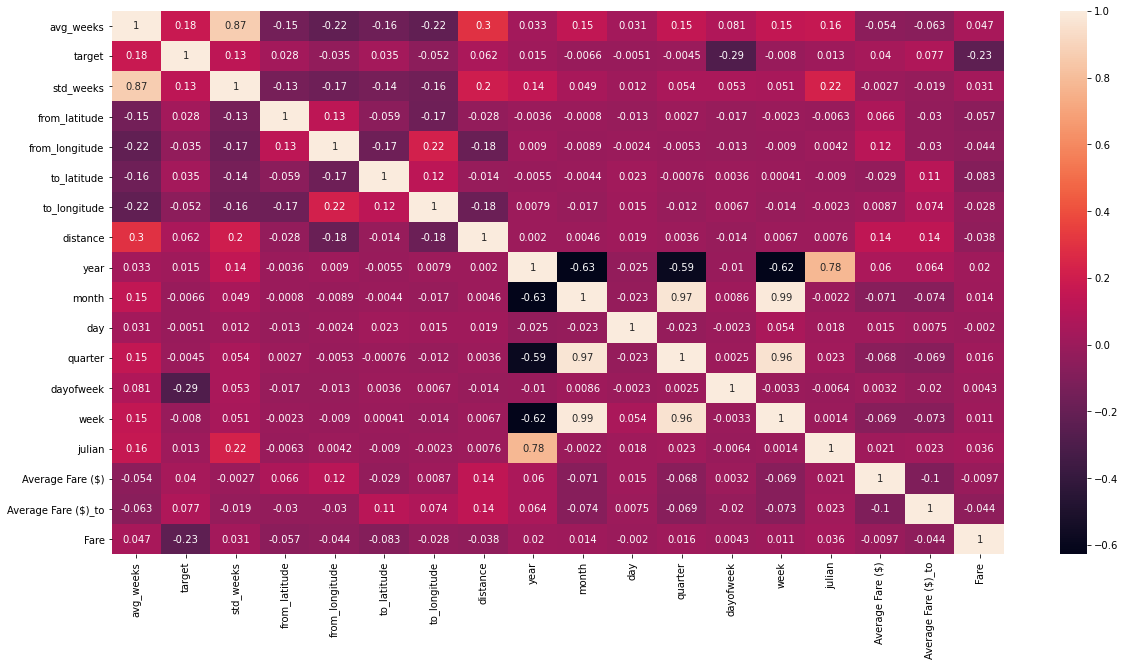

In [40]:
fig = plt.figure(figsize=(20, 10))
sns.heatmap(merged_df.corr(), annot=True)

Add holidays column to datasets

In [41]:
# merged_df['holidays'] = 0
# for i in range(merged_df.shape[0]):
#     if merged_df['flight_date'][i] in holidays:
#         merged_df['holidays'][i] = 1

In [42]:
# merged_df_sub['holidays'] = 0
# for i in range(merged_df_sub.shape[0]):
#     if merged_df_sub['flight_date'][i] in holidays:
#         merged_df_sub['holidays'][i] = 1

In [43]:
print(merged_df.shape)
print(merged_df_sub.shape)

(8896, 21)
(2232, 20)


# Final Dataset

In [44]:
# merged_df.to_csv('final_data_train_merged.csv', index=False)

In [45]:
# merged_df_sub.to_csv('final_data_test_merged.csv', index=False)

In [46]:
data = pd.read_csv('final_data_train_merged.csv', parse_dates=['flight_date'])
data_submission = pd.read_csv('final_data_test_merged.csv', parse_dates=['flight_date'])

# Pipeline

**We didnt use pipeline because we wont ignore unknow categories when using onehotencoding OR using many ones OR slicing it ✌️😋😎**

# Finding the best models 

To do that we ll use a python librairy called **PyCaret**.

PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows. It is an end-to-end machine learning and model management tool that speeds up the experiment cycle exponentially.

- link: https://github.com/pycaret/pycaret

In [47]:
import pycaret.regression as pycaret_reg

In [48]:
main_regression = pycaret_reg.setup(data = data.drop(['flight_date'], axis=1), 
                                    target = 'target', session_id=123, use_gpu=True, 
                                    numeric_features=['year', 'month', 'dayofweek', 'week']) 

,Description,Value
0,session_id,123
1,Target,target
2,Original Data,"(8896, 20)"
3,Missing Values,False
4,Numeric Features,16
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6227, 60)"


Test some models to see the best ones

In [49]:
best = pycaret_reg.compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.2498,0.1137,0.3367,0.8731,0.0292,0.0232,1.7430
xgboost,Extreme Gradient Boosting,0.2588,0.1223,0.3494,0.8632,0.0303,0.0240,1.2000
lightgbm,Light Gradient Boosting Machine,0.2661,0.1280,0.3574,0.8570,0.0309,0.0247,1.0690
et,Extra Trees Regressor,0.3050,0.1850,0.4295,0.7933,0.0372,0.0284,1.4560
rf,Random Forest Regressor,0.3090,0.1862,0.4309,0.7920,0.0372,0.0287,1.4040
gbr,Gradient Boosting Regressor,0.3673,0.2282,0.4770,0.7453,0.0408,0.0339,0.8760
dt,Decision Tree Regressor,0.4311,0.3694,0.6075,0.5853,0.0523,0.0400,0.0590
ada,AdaBoost Regressor,0.5283,0.4483,0.6691,0.4986,0.0559,0.0480,0.4660
ridge,Ridge Regression,0.5545,0.5308,0.7271,0.4084,0.0626,0.0518,0.0090
br,Bayesian Ridge,0.5546,0.5309,0.7272,0.4084,0.0626,0.0518,0.0240


Using pycaret, the best models are: **catboost, xgboost, lightgbm and random Forest**. Also we ll add **linear regression** as a **Baseline**.

##### Lets tune these models (just a small tuning with 10 iterations only to have an idea where to search)

##### CATBOOST

In [50]:
cat = pycaret_reg.create_model('catboost', fold = 5)
tuned_cat = pycaret_reg.tune_model(cat, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2610,0.1198,0.3461,0.8588,0.0302,0.0242
1,0.2526,0.1141,0.3378,0.8712,0.0287,0.0232
2,0.2548,0.1123,0.3350,0.8601,0.0287,0.0236
3,0.2581,0.1196,0.3458,0.8598,0.0297,0.0238
4,0.2464,0.1112,0.3335,0.8781,0.0290,0.0230
5,0.2749,0.1335,0.3654,0.8555,0.0317,0.0255
6,0.2804,0.1545,0.3931,0.8579,0.0358,0.0268
7,0.2542,0.1203,0.3468,0.8551,0.0302,0.0236
8,0.2610,0.1212,0.3481,0.8638,0.0300,0.0240
9,0.2684,0.1256,0.3544,0.8636,0.0302,0.0247


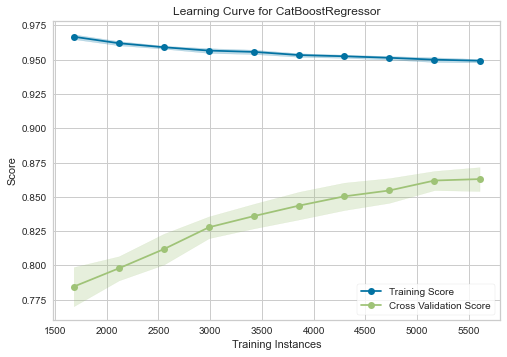

In [51]:
pycaret_reg.plot_model(tuned_cat, plot = 'learning')

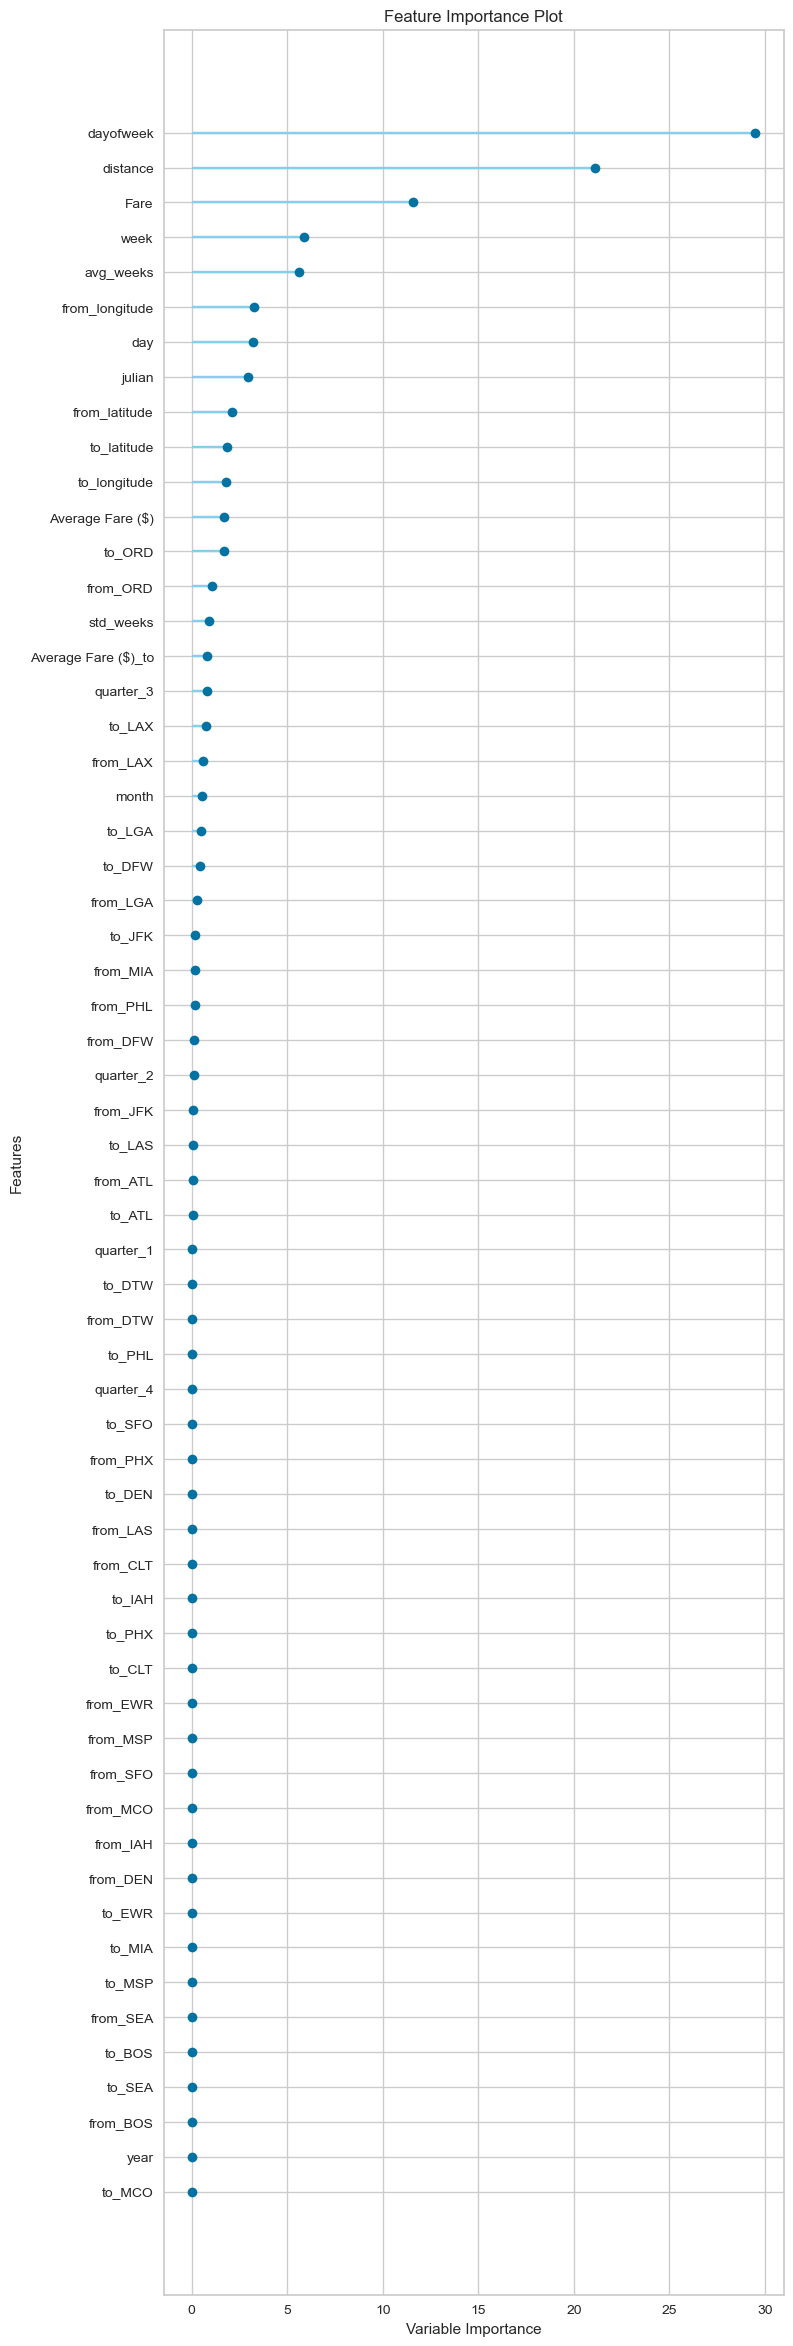

In [52]:
pycaret_reg.plot_model(tuned_cat, plot = 'feature_all')

##### XGBOOST

In [53]:
xgb = pycaret_reg.create_model('xgboost', fold = 5)
tuned_xgb = pycaret_reg.tune_model(xgb, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2471,0.1069,0.3269,0.8741,0.0286,0.0229
1,0.2437,0.1067,0.3266,0.8796,0.0278,0.0224
2,0.2392,0.1003,0.3167,0.8750,0.0273,0.0222
3,0.2530,0.1130,0.3362,0.8675,0.0289,0.0234
4,0.2385,0.1065,0.3263,0.8832,0.0282,0.0222
5,0.2695,0.1293,0.3595,0.8602,0.0313,0.0250
6,0.2672,0.1380,0.3715,0.8730,0.0335,0.0254
7,0.2434,0.1066,0.3265,0.8716,0.0284,0.0226
8,0.2443,0.1067,0.3267,0.8801,0.0281,0.0225
9,0.2685,0.1226,0.3501,0.8668,0.0301,0.0248


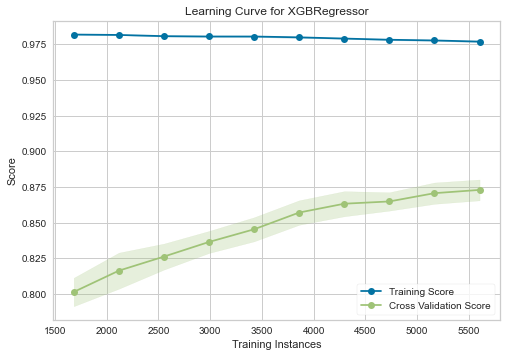

In [54]:
pycaret_reg.plot_model(tuned_xgb, plot = 'learning')

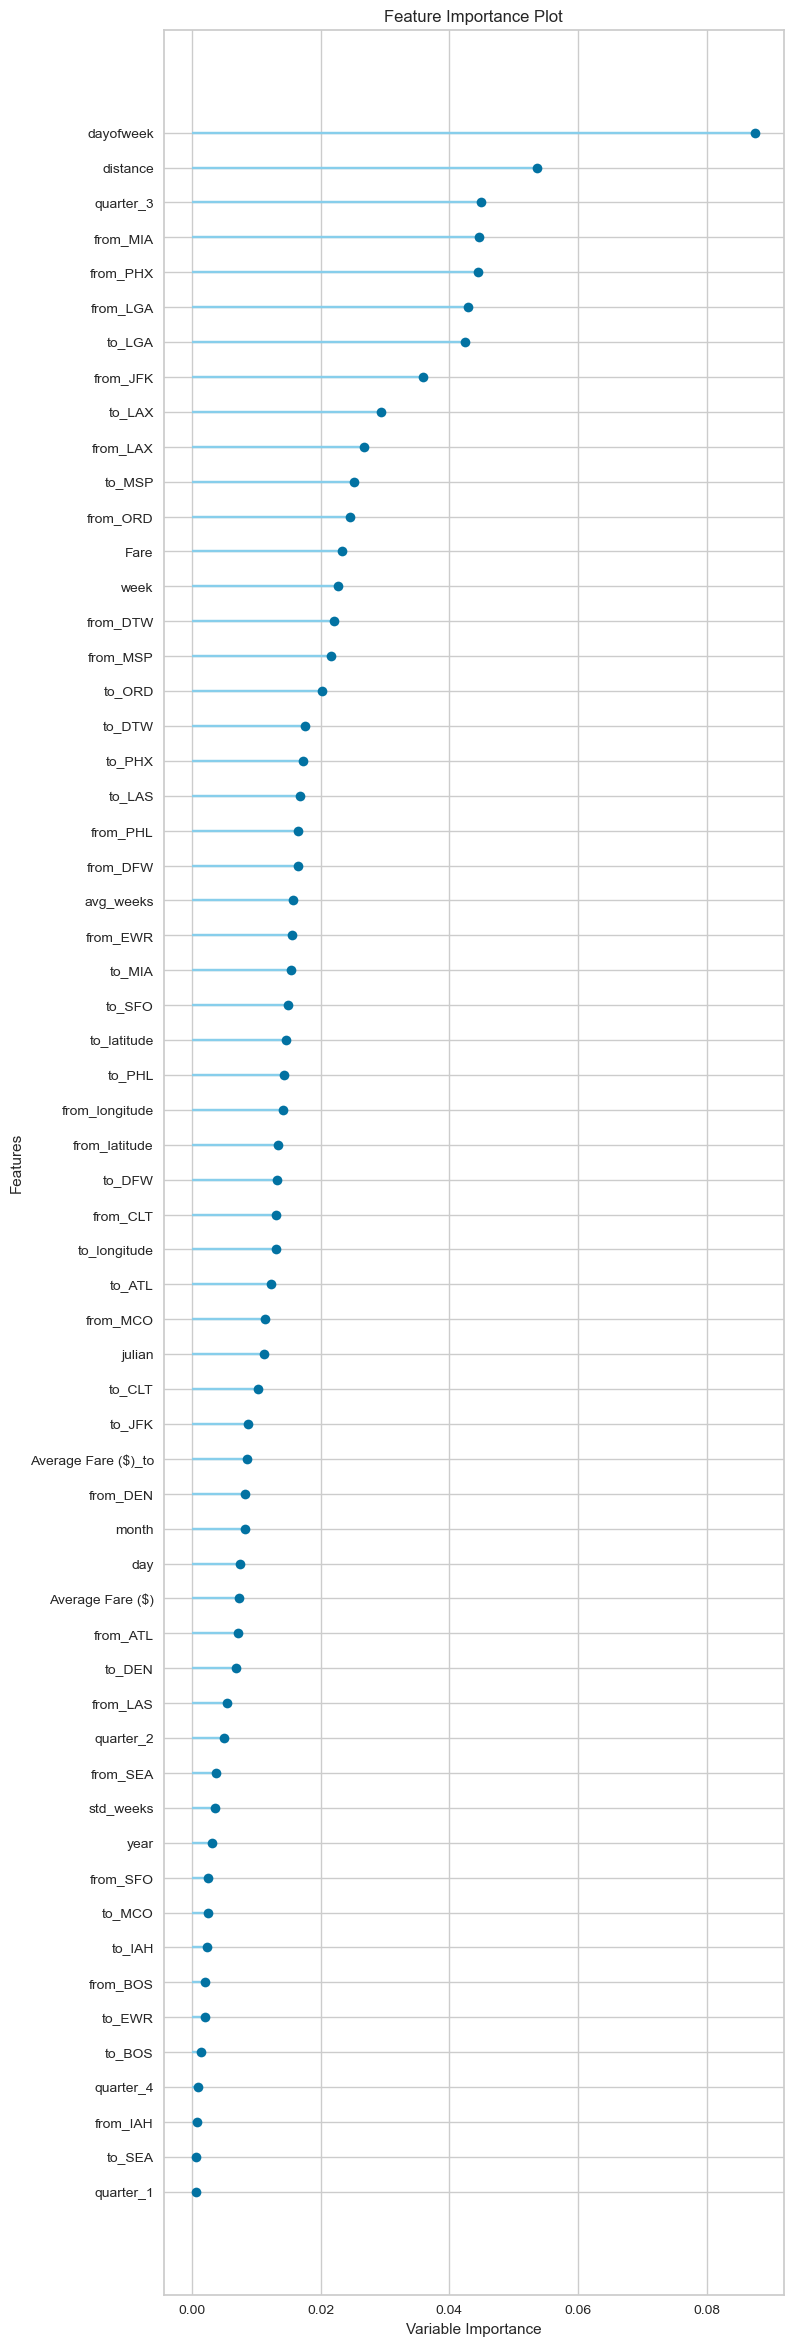

In [55]:
pycaret_reg.plot_model(tuned_xgb, plot = 'feature_all')

##### LIGHTGBM

In [56]:
lgbm = pycaret_reg.create_model('lightgbm', fold = 5)
tuned_lgbm = pycaret_reg.tune_model(lgbm, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2895,0.1513,0.3890,0.8217,0.0343,0.0270
1,0.2928,0.1565,0.3955,0.8234,0.0340,0.0271
2,0.2752,0.1404,0.3747,0.8249,0.0322,0.0255
3,0.2892,0.1518,0.3896,0.8220,0.0337,0.0268
4,0.2761,0.1451,0.3810,0.8409,0.0332,0.0258
5,0.3087,0.1733,0.4163,0.8125,0.0356,0.0284
6,0.3176,0.2184,0.4674,0.7991,0.0427,0.0305
7,0.2883,0.1528,0.3910,0.8158,0.0341,0.0268
8,0.2849,0.1479,0.3846,0.8338,0.0332,0.0263
9,0.2976,0.1539,0.3923,0.8327,0.0334,0.0274


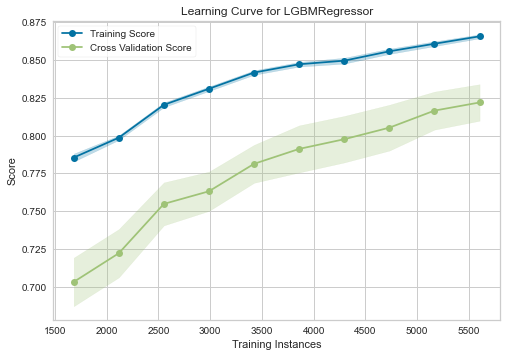

In [57]:
pycaret_reg.plot_model(tuned_lgbm, plot = 'learning')

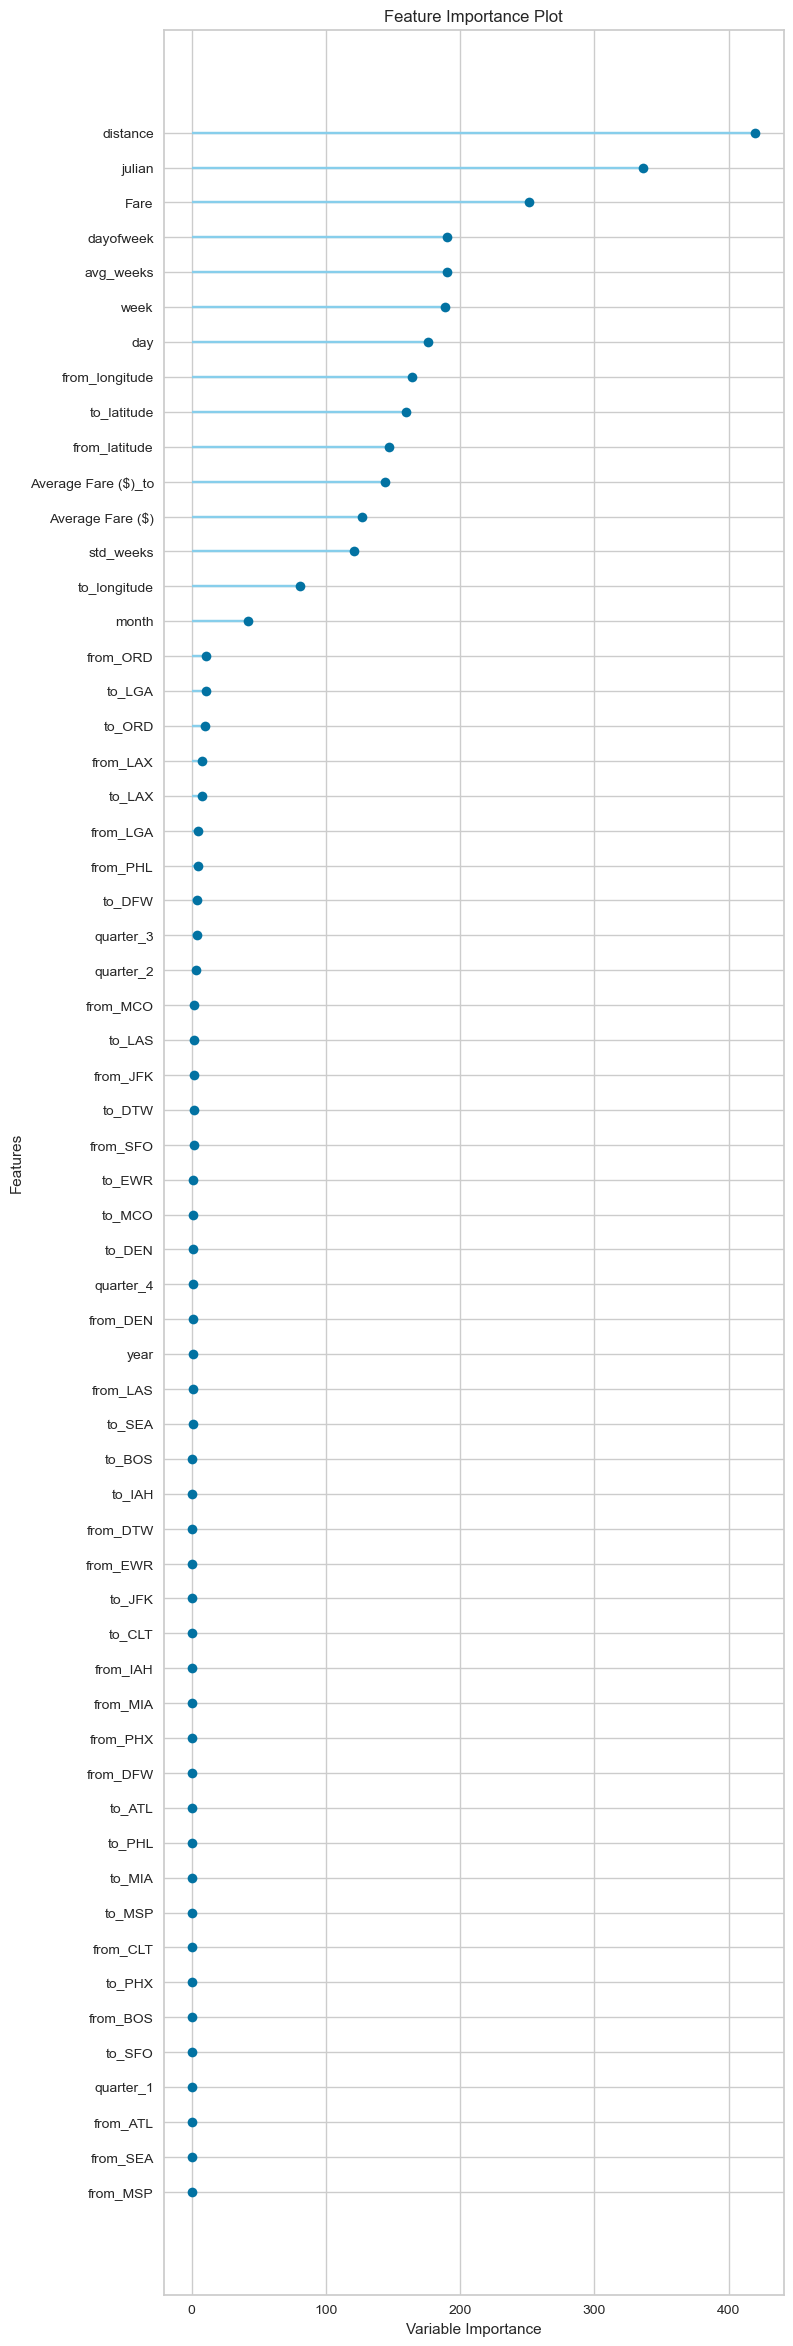

In [58]:
pycaret_reg.plot_model(tuned_lgbm, plot = 'feature_all')

##### RANDOM FOREST

In [59]:
rf = pycaret_reg.create_model('rf', fold = 5)
tuned_rf = pycaret_reg.tune_model(rf, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4089,0.2910,0.5395,0.6570,0.0469,0.0380
1,0.4156,0.3109,0.5576,0.6491,0.0480,0.0385
2,0.4025,0.2756,0.5250,0.6564,0.0447,0.0372
3,0.4263,0.3075,0.5545,0.6394,0.0478,0.0396
4,0.4224,0.3106,0.5573,0.6595,0.0485,0.0394
5,0.4342,0.3286,0.5733,0.6445,0.0485,0.0400
6,0.4556,0.3996,0.6322,0.6324,0.0568,0.0437
7,0.4118,0.2974,0.5453,0.6416,0.0468,0.0382
8,0.3991,0.2757,0.5251,0.6902,0.0448,0.0367
9,0.4269,0.3019,0.5495,0.6719,0.0467,0.0393


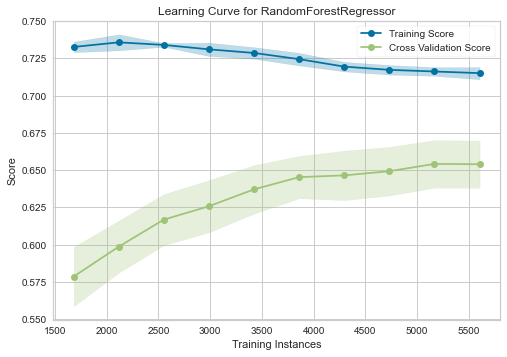

In [60]:
pycaret_reg.plot_model(tuned_rf, plot = 'learning')

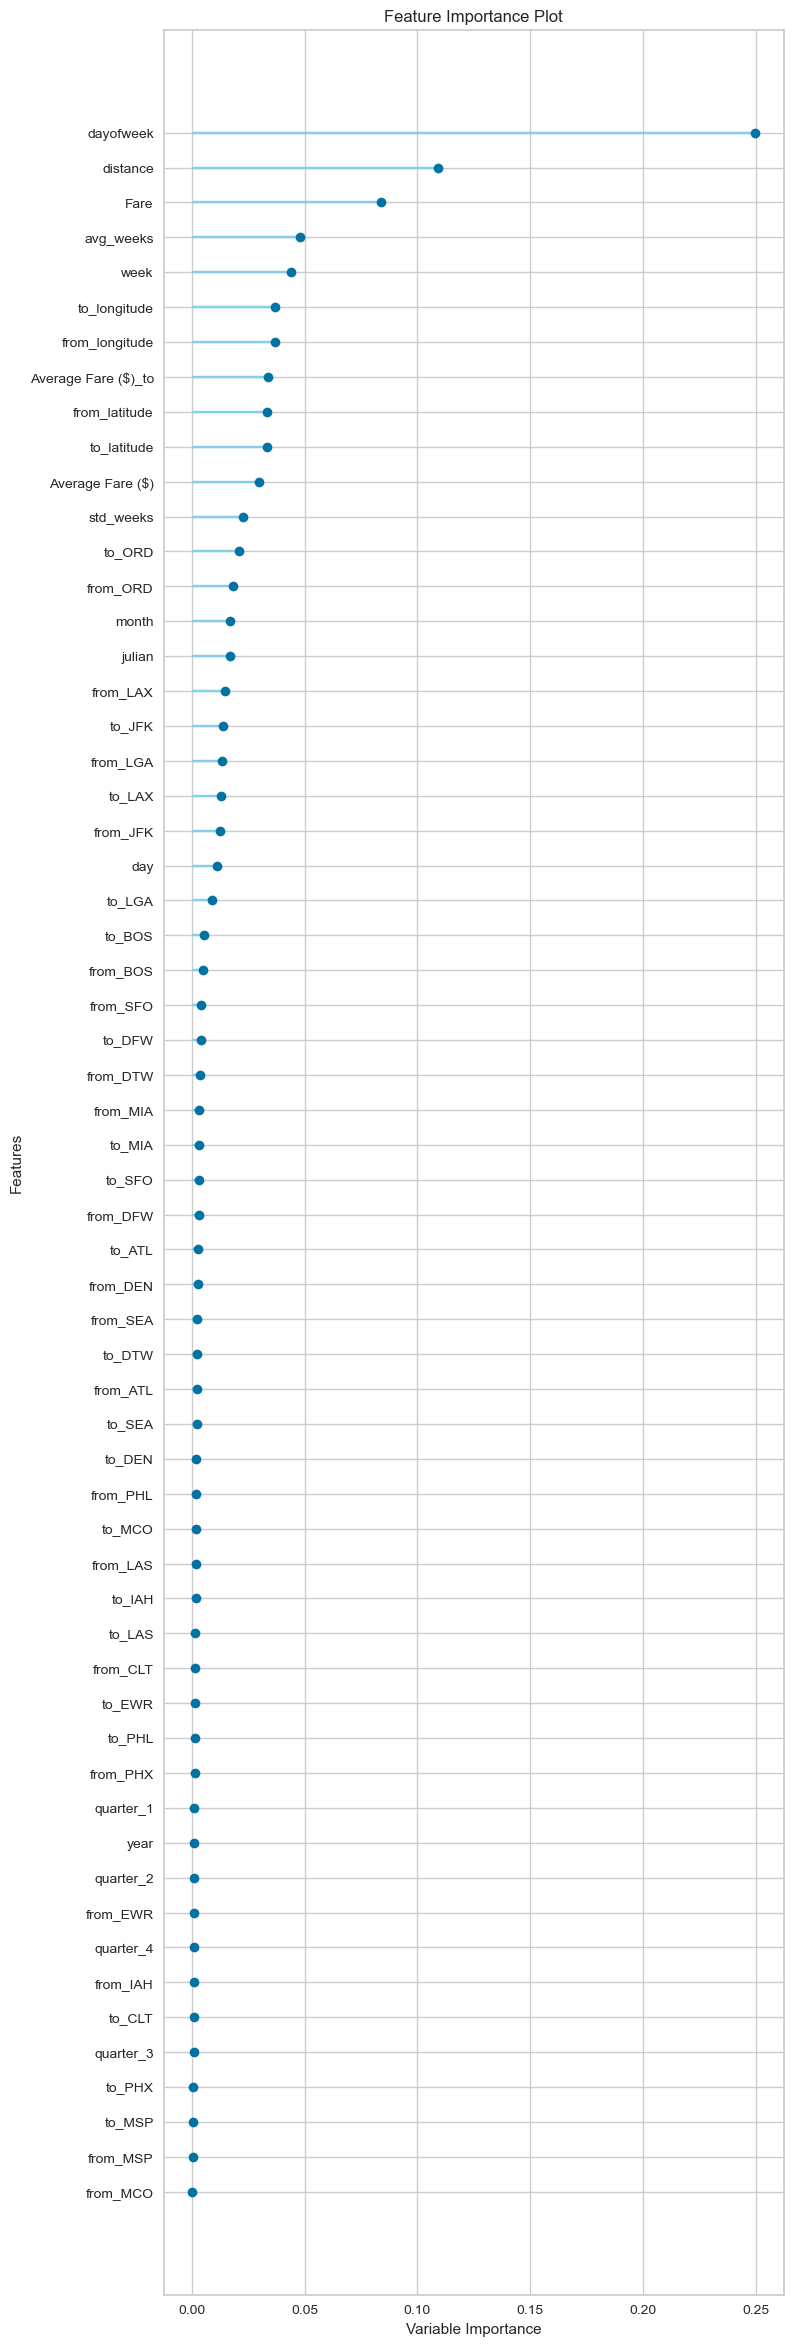

In [61]:
pycaret_reg.plot_model(tuned_rf, plot = 'feature_all')

##### LINEAR REGRESSION

In [62]:
lr = pycaret_reg.create_model('lr', fold = 5)
tuned_lr = pycaret_reg.tune_model(lr, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5305,0.4806,0.6932,0.4337,0.0598,0.0494
1,0.5640,0.5562,0.7458,0.3722,0.0643,0.0527
2,0.5308,0.4677,0.6839,0.4171,0.0583,0.0492
3,0.5648,0.5294,0.7276,0.3791,0.0625,0.0527
4,0.5398,0.5015,0.7081,0.4502,0.0614,0.0505
5,0.5495,0.4950,0.7036,0.4645,0.0596,0.0507
6,0.6249,0.7315,0.8552,0.3272,0.0759,0.0600
7,0.5406,0.5031,0.7093,0.3937,0.0609,0.0505
8,0.5498,0.5391,0.7343,0.3942,0.0630,0.0511
9,0.5553,0.5098,0.7140,0.4461,0.0609,0.0514


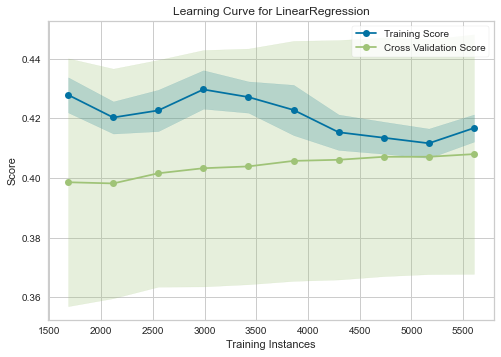

In [63]:
pycaret_reg.plot_model(tuned_lr, plot = 'learning')

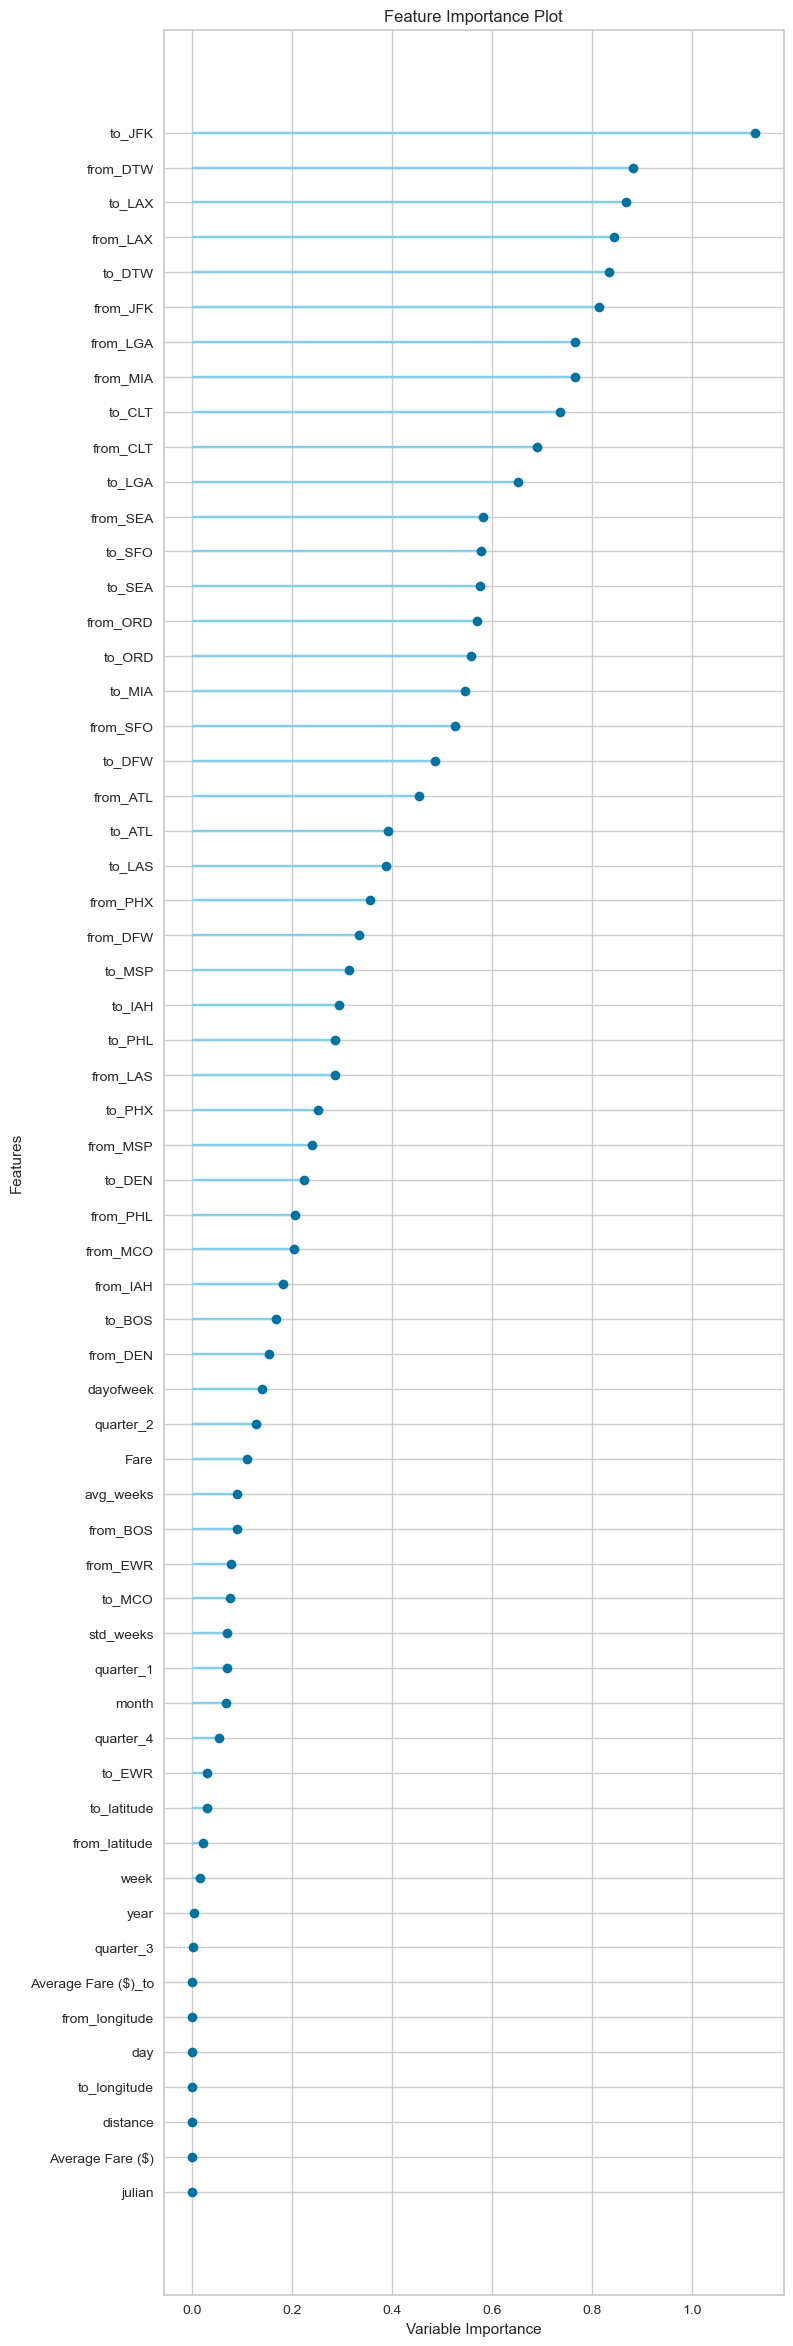

In [64]:
pycaret_reg.plot_model(tuned_lr, plot = 'feature_all')

#### We can conclude that the best model is Xgboost

# Prediction

#### Preprocessing 

In [65]:
y = data.target
X = data.drop(['target', 'flight_date'], axis=1)

In [66]:
X_processed = pd.get_dummies(X)

In [67]:
X_processed

,avg_weeks,std_weeks,from_latitude,from_longitude,to_latitude,to_longitude,distance,year,dayofweek,month,...,to_LAX,to_LGA,to_MCO,to_MIA,to_MSP,to_ORD,to_PHL,to_PHX,to_SEA,to_SFO
0,12.875000,9.812647,41.974163,-87.907320,32.899810,-97.040340,1289.698532,2012,1,6,...,0,0,0,0,0,0,0,0,0,0
1,14.285714,9.466734,36.084000,-115.153740,39.856100,-104.673740,1010.700812,2012,0,9,...,0,0,0,0,0,0,0,0,0,0
2,10.863636,9.035883,39.856100,-104.673740,33.941590,-118.408530,1386.808962,2012,4,10,...,1,0,0,0,0,0,0,0,0,0
3,11.480000,7.990202,33.640728,-84.427704,41.974163,-87.907320,974.145965,2011,6,10,...,0,0,0,0,0,1,0,0,0,0
4,11.450000,9.517159,39.856100,-104.673740,37.621310,-122.378950,1556.562600,2012,1,2,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8891,11.045455,7.791798,39.856100,-104.673740,33.437267,-112.007790,967.511116,2011,3,11,...,0,0,0,0,0,0,0,1,0,0
8892,11.000000,7.937254,33.640728,-84.427704,39.856100,-104.673740,1929.754252,2012,5,9,...,0,0,0,0,0,0,0,0,0,0
8893,9.476190,6.903760,41.974163,-87.907320,40.689533,-74.174460,1157.147451,2012,4,8,...,0,0,0,0,0,0,0,0,0,0
8894,10.250000,7.107261,41.974163,-87.907320,29.990220,-95.336784,1487.504532,2012,1,7,...,0,0,0,0,0,0,0,0,0,0


#### Train-Test split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=30)

#### Models

In [69]:
rf_model = RandomForestRegressor(n_estimators=1600, n_jobs=-1)

In [70]:
xgb_model = XGBRegressor(n_estimators=4100, max_depth=10, min_child_weight=5, gamma=0.4, 
                         eval_metric='rmse', eta=0.005, colsample_bytree=0.7, subsample=0.6, n_jobs=-1)

In [71]:
cbt_model = CatBoostRegressor()

In [72]:
lgbm_model = LGBMRegressor(n_estimators=1600, learning_rate=10**-3, n_jobs=-1)

#### Fit

In [73]:
# fiting random forest
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1600, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [74]:
# fiting xgboost
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.005,
             eval_metric='rmse', gamma=0.4, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.00499999989,
             max_delta_step=0, max_depth=10, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=4100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [75]:
# fiting catboost
cbt_model.fit(X_train, y_train)

Learning rate set to 0.055826
0:	learn: 0.9309970	total: 2.47ms	remaining: 2.47s
1:	learn: 0.9114471	total: 4.82ms	remaining: 2.4s
2:	learn: 0.8926986	total: 8.06ms	remaining: 2.68s
3:	learn: 0.8776621	total: 10.1ms	remaining: 2.52s
4:	learn: 0.8631488	total: 12.3ms	remaining: 2.45s
5:	learn: 0.8484614	total: 14.3ms	remaining: 2.38s
6:	learn: 0.8354152	total: 16.4ms	remaining: 2.32s
7:	learn: 0.8222276	total: 18.6ms	remaining: 2.3s
8:	learn: 0.8078969	total: 22.1ms	remaining: 2.43s
9:	learn: 0.7972330	total: 24.8ms	remaining: 2.45s
10:	learn: 0.7878908	total: 27.2ms	remaining: 2.45s
11:	learn: 0.7789449	total: 29.6ms	remaining: 2.44s
12:	learn: 0.7700118	total: 31.7ms	remaining: 2.41s
13:	learn: 0.7627549	total: 33.8ms	remaining: 2.38s
14:	learn: 0.7551184	total: 36.2ms	remaining: 2.38s
15:	learn: 0.7468854	total: 39.3ms	remaining: 2.42s
16:	learn: 0.7387111	total: 41.4ms	remaining: 2.39s
17:	learn: 0.7314294	total: 43.2ms	remaining: 2.36s
18:	learn: 0.7249243	total: 45.1ms	remaining: 

235:	learn: 0.3874394	total: 525ms	remaining: 1.7s
236:	learn: 0.3865629	total: 527ms	remaining: 1.7s
237:	learn: 0.3860031	total: 529ms	remaining: 1.7s
238:	learn: 0.3854795	total: 531ms	remaining: 1.69s
239:	learn: 0.3850578	total: 533ms	remaining: 1.69s
240:	learn: 0.3846954	total: 535ms	remaining: 1.68s
241:	learn: 0.3841770	total: 536ms	remaining: 1.68s
242:	learn: 0.3835488	total: 538ms	remaining: 1.68s
243:	learn: 0.3831772	total: 541ms	remaining: 1.68s
244:	learn: 0.3826390	total: 543ms	remaining: 1.67s
245:	learn: 0.3818364	total: 545ms	remaining: 1.67s
246:	learn: 0.3815068	total: 547ms	remaining: 1.67s
247:	learn: 0.3808502	total: 549ms	remaining: 1.66s
248:	learn: 0.3803613	total: 551ms	remaining: 1.66s
249:	learn: 0.3799671	total: 553ms	remaining: 1.66s
250:	learn: 0.3796488	total: 555ms	remaining: 1.66s
251:	learn: 0.3790192	total: 558ms	remaining: 1.66s
252:	learn: 0.3786228	total: 560ms	remaining: 1.65s
253:	learn: 0.3781964	total: 562ms	remaining: 1.65s
254:	learn: 0.3

412:	learn: 0.3218982	total: 882ms	remaining: 1.25s
413:	learn: 0.3215150	total: 884ms	remaining: 1.25s
414:	learn: 0.3212489	total: 885ms	remaining: 1.25s
415:	learn: 0.3209779	total: 887ms	remaining: 1.25s
416:	learn: 0.3209015	total: 890ms	remaining: 1.24s
417:	learn: 0.3206111	total: 892ms	remaining: 1.24s
418:	learn: 0.3203234	total: 894ms	remaining: 1.24s
419:	learn: 0.3200563	total: 896ms	remaining: 1.24s
420:	learn: 0.3197905	total: 898ms	remaining: 1.23s
421:	learn: 0.3195191	total: 899ms	remaining: 1.23s
422:	learn: 0.3193422	total: 901ms	remaining: 1.23s
423:	learn: 0.3191411	total: 903ms	remaining: 1.23s
424:	learn: 0.3188941	total: 906ms	remaining: 1.23s
425:	learn: 0.3186615	total: 909ms	remaining: 1.23s
426:	learn: 0.3183692	total: 912ms	remaining: 1.22s
427:	learn: 0.3181524	total: 914ms	remaining: 1.22s
428:	learn: 0.3179371	total: 915ms	remaining: 1.22s
429:	learn: 0.3177742	total: 917ms	remaining: 1.22s
430:	learn: 0.3175086	total: 919ms	remaining: 1.21s
431:	learn: 

578:	learn: 0.2867145	total: 1.23s	remaining: 895ms
579:	learn: 0.2865175	total: 1.23s	remaining: 892ms
580:	learn: 0.2863393	total: 1.23s	remaining: 890ms
581:	learn: 0.2861268	total: 1.24s	remaining: 888ms
582:	learn: 0.2859324	total: 1.24s	remaining: 886ms
583:	learn: 0.2857799	total: 1.24s	remaining: 883ms
584:	learn: 0.2856186	total: 1.24s	remaining: 881ms
585:	learn: 0.2854207	total: 1.24s	remaining: 878ms
586:	learn: 0.2852775	total: 1.25s	remaining: 876ms
587:	learn: 0.2850898	total: 1.25s	remaining: 874ms
588:	learn: 0.2848635	total: 1.25s	remaining: 871ms
589:	learn: 0.2846712	total: 1.25s	remaining: 869ms
590:	learn: 0.2845020	total: 1.25s	remaining: 867ms
591:	learn: 0.2842610	total: 1.25s	remaining: 864ms
592:	learn: 0.2841477	total: 1.25s	remaining: 862ms
593:	learn: 0.2839787	total: 1.26s	remaining: 860ms
594:	learn: 0.2837673	total: 1.26s	remaining: 857ms
595:	learn: 0.2836369	total: 1.26s	remaining: 855ms
596:	learn: 0.2833888	total: 1.26s	remaining: 852ms
597:	learn: 

752:	learn: 0.2590852	total: 1.59s	remaining: 521ms
753:	learn: 0.2589430	total: 1.59s	remaining: 519ms
754:	learn: 0.2588497	total: 1.59s	remaining: 517ms
755:	learn: 0.2587386	total: 1.59s	remaining: 515ms
756:	learn: 0.2585808	total: 1.6s	remaining: 513ms
757:	learn: 0.2584816	total: 1.6s	remaining: 511ms
758:	learn: 0.2583563	total: 1.6s	remaining: 509ms
759:	learn: 0.2582466	total: 1.61s	remaining: 507ms
760:	learn: 0.2580831	total: 1.61s	remaining: 505ms
761:	learn: 0.2579347	total: 1.61s	remaining: 503ms
762:	learn: 0.2577341	total: 1.61s	remaining: 501ms
763:	learn: 0.2576704	total: 1.62s	remaining: 499ms
764:	learn: 0.2575127	total: 1.62s	remaining: 498ms
765:	learn: 0.2573347	total: 1.62s	remaining: 496ms
766:	learn: 0.2571792	total: 1.62s	remaining: 494ms
767:	learn: 0.2570202	total: 1.63s	remaining: 491ms
768:	learn: 0.2569283	total: 1.63s	remaining: 489ms
769:	learn: 0.2567984	total: 1.63s	remaining: 487ms
770:	learn: 0.2566521	total: 1.63s	remaining: 485ms
771:	learn: 0.2

916:	learn: 0.2378737	total: 1.94s	remaining: 176ms
917:	learn: 0.2377231	total: 1.94s	remaining: 174ms
918:	learn: 0.2376213	total: 1.95s	remaining: 172ms
919:	learn: 0.2375170	total: 1.95s	remaining: 169ms
920:	learn: 0.2374010	total: 1.95s	remaining: 167ms
921:	learn: 0.2373125	total: 1.95s	remaining: 165ms
922:	learn: 0.2372154	total: 1.95s	remaining: 163ms
923:	learn: 0.2371113	total: 1.96s	remaining: 161ms
924:	learn: 0.2369600	total: 1.96s	remaining: 159ms
925:	learn: 0.2368020	total: 1.96s	remaining: 157ms
926:	learn: 0.2366586	total: 1.96s	remaining: 154ms
927:	learn: 0.2365570	total: 1.96s	remaining: 152ms
928:	learn: 0.2364694	total: 1.96s	remaining: 150ms
929:	learn: 0.2363743	total: 1.97s	remaining: 148ms
930:	learn: 0.2362908	total: 1.97s	remaining: 146ms
931:	learn: 0.2362238	total: 1.97s	remaining: 144ms
932:	learn: 0.2361716	total: 1.97s	remaining: 142ms
933:	learn: 0.2360987	total: 1.97s	remaining: 139ms
934:	learn: 0.2359636	total: 1.97s	remaining: 137ms
935:	learn: 

In [76]:
# fiting lgbm
lgbm_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.001, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1600, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### Params tuning
we tune the xgboost's hyperparametrs (hard tuning)

In [77]:
# model tuning

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

# A parameter grid for XGBoost
params = {
    'n_estimators':[i*100 for i in range(1, 50, 4)],
    'min_child_weight':[4,5,6], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2, 3, 4, 6, 7, 8, 9, 10],
    'eval_metric': ['rmse'],
    'eta': [i/1000 for i in range(1,6,2)],
}

reg = XGBRegressor(tree_method = 'gpu_hist')

# run randomized search
n_iter_search = 150
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=4, scoring='neg_root_mean_squared_error', verbose=10)

start = time.time()

# X_max = pd.get_dummies(X)
# random_search.fit(X_max, y)

# print(random_search.best_params_)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 0.00 seconds for 150 candidates parameter settings.


#### Learning curve

[0]	validation_0-rmse:10.56012	validation_1-rmse:10.60363
[1]	validation_0-rmse:10.50776	validation_1-rmse:10.55122
[2]	validation_0-rmse:10.45565	validation_1-rmse:10.49910
[3]	validation_0-rmse:10.40369	validation_1-rmse:10.44711
[4]	validation_0-rmse:10.35202	validation_1-rmse:10.39540
[5]	validation_0-rmse:10.30058	validation_1-rmse:10.34394
[6]	validation_0-rmse:10.24954	validation_1-rmse:10.29285
[7]	validation_0-rmse:10.19867	validation_1-rmse:10.24198
[8]	validation_0-rmse:10.14804	validation_1-rmse:10.19131
[9]	validation_0-rmse:10.09767	validation_1-rmse:10.14084
[10]	validation_0-rmse:10.04749	validation_1-rmse:10.09062
[11]	validation_0-rmse:9.99756	validation_1-rmse:10.04065
[12]	validation_0-rmse:9.94803	validation_1-rmse:9.99103
[13]	validation_0-rmse:9.89863	validation_1-rmse:9.94163
[14]	validation_0-rmse:9.84941	validation_1-rmse:9.89241
[15]	validation_0-rmse:9.80055	validation_1-rmse:9.84352
[16]	validation_0-rmse:9.75188	validation_1-rmse:9.79484
[17]	validation_0-

[143]	validation_0-rmse:5.20398	validation_1-rmse:5.24060
[144]	validation_0-rmse:5.17847	validation_1-rmse:5.21506
[145]	validation_0-rmse:5.15313	validation_1-rmse:5.18970
[146]	validation_0-rmse:5.12786	validation_1-rmse:5.16443
[147]	validation_0-rmse:5.10276	validation_1-rmse:5.13929
[148]	validation_0-rmse:5.07777	validation_1-rmse:5.11424
[149]	validation_0-rmse:5.05288	validation_1-rmse:5.08931
[150]	validation_0-rmse:5.02812	validation_1-rmse:5.06452
[151]	validation_0-rmse:5.00353	validation_1-rmse:5.03983
[152]	validation_0-rmse:4.97905	validation_1-rmse:5.01537
[153]	validation_0-rmse:4.95466	validation_1-rmse:4.99094
[154]	validation_0-rmse:4.93043	validation_1-rmse:4.96666
[155]	validation_0-rmse:4.90639	validation_1-rmse:4.94255
[156]	validation_0-rmse:4.88239	validation_1-rmse:4.91846
[157]	validation_0-rmse:4.85846	validation_1-rmse:4.89448
[158]	validation_0-rmse:4.83469	validation_1-rmse:4.87069
[159]	validation_0-rmse:4.81106	validation_1-rmse:4.84706
[160]	validati

[285]	validation_0-rmse:2.61374	validation_1-rmse:2.64332
[286]	validation_0-rmse:2.60139	validation_1-rmse:2.63095
[287]	validation_0-rmse:2.58901	validation_1-rmse:2.61852
[288]	validation_0-rmse:2.57674	validation_1-rmse:2.60618
[289]	validation_0-rmse:2.56447	validation_1-rmse:2.59390
[290]	validation_0-rmse:2.55231	validation_1-rmse:2.58167
[291]	validation_0-rmse:2.54019	validation_1-rmse:2.56949
[292]	validation_0-rmse:2.52805	validation_1-rmse:2.55727
[293]	validation_0-rmse:2.51606	validation_1-rmse:2.54524
[294]	validation_0-rmse:2.50409	validation_1-rmse:2.53324
[295]	validation_0-rmse:2.49220	validation_1-rmse:2.52135
[296]	validation_0-rmse:2.48036	validation_1-rmse:2.50945
[297]	validation_0-rmse:2.46856	validation_1-rmse:2.49755
[298]	validation_0-rmse:2.45684	validation_1-rmse:2.48570
[299]	validation_0-rmse:2.44518	validation_1-rmse:2.47399
[300]	validation_0-rmse:2.43363	validation_1-rmse:2.46241
[301]	validation_0-rmse:2.42208	validation_1-rmse:2.45077
[302]	validati

[427]	validation_0-rmse:1.35458	validation_1-rmse:1.37866
[428]	validation_0-rmse:1.34856	validation_1-rmse:1.37262
[429]	validation_0-rmse:1.34256	validation_1-rmse:1.36666
[430]	validation_0-rmse:1.33658	validation_1-rmse:1.36067
[431]	validation_0-rmse:1.33062	validation_1-rmse:1.35468
[432]	validation_0-rmse:1.32477	validation_1-rmse:1.34882
[433]	validation_0-rmse:1.31891	validation_1-rmse:1.34292
[434]	validation_0-rmse:1.31311	validation_1-rmse:1.33714
[435]	validation_0-rmse:1.30732	validation_1-rmse:1.33137
[436]	validation_0-rmse:1.30150	validation_1-rmse:1.32552
[437]	validation_0-rmse:1.29575	validation_1-rmse:1.31976
[438]	validation_0-rmse:1.29006	validation_1-rmse:1.31405
[439]	validation_0-rmse:1.28434	validation_1-rmse:1.30832
[440]	validation_0-rmse:1.27871	validation_1-rmse:1.30267
[441]	validation_0-rmse:1.27311	validation_1-rmse:1.29710
[442]	validation_0-rmse:1.26749	validation_1-rmse:1.29146
[443]	validation_0-rmse:1.26188	validation_1-rmse:1.28583
[444]	validati

[569]	validation_0-rmse:0.74992	validation_1-rmse:0.77665
[570]	validation_0-rmse:0.74704	validation_1-rmse:0.77384
[571]	validation_0-rmse:0.74424	validation_1-rmse:0.77107
[572]	validation_0-rmse:0.74148	validation_1-rmse:0.76832
[573]	validation_0-rmse:0.73874	validation_1-rmse:0.76564
[574]	validation_0-rmse:0.73597	validation_1-rmse:0.76290
[575]	validation_0-rmse:0.73320	validation_1-rmse:0.76020
[576]	validation_0-rmse:0.73041	validation_1-rmse:0.75749
[577]	validation_0-rmse:0.72762	validation_1-rmse:0.75482
[578]	validation_0-rmse:0.72489	validation_1-rmse:0.75216
[579]	validation_0-rmse:0.72217	validation_1-rmse:0.74953
[580]	validation_0-rmse:0.71945	validation_1-rmse:0.74689
[581]	validation_0-rmse:0.71679	validation_1-rmse:0.74424
[582]	validation_0-rmse:0.71416	validation_1-rmse:0.74168
[583]	validation_0-rmse:0.71149	validation_1-rmse:0.73912
[584]	validation_0-rmse:0.70884	validation_1-rmse:0.73651
[585]	validation_0-rmse:0.70624	validation_1-rmse:0.73392
[586]	validati

[711]	validation_0-rmse:0.46876	validation_1-rmse:0.50647
[712]	validation_0-rmse:0.46748	validation_1-rmse:0.50528
[713]	validation_0-rmse:0.46626	validation_1-rmse:0.50409
[714]	validation_0-rmse:0.46498	validation_1-rmse:0.50294
[715]	validation_0-rmse:0.46373	validation_1-rmse:0.50176
[716]	validation_0-rmse:0.46253	validation_1-rmse:0.50060
[717]	validation_0-rmse:0.46127	validation_1-rmse:0.49941
[718]	validation_0-rmse:0.46011	validation_1-rmse:0.49831
[719]	validation_0-rmse:0.45887	validation_1-rmse:0.49719
[720]	validation_0-rmse:0.45765	validation_1-rmse:0.49610
[721]	validation_0-rmse:0.45647	validation_1-rmse:0.49505
[722]	validation_0-rmse:0.45523	validation_1-rmse:0.49391
[723]	validation_0-rmse:0.45402	validation_1-rmse:0.49280
[724]	validation_0-rmse:0.45286	validation_1-rmse:0.49173
[725]	validation_0-rmse:0.45167	validation_1-rmse:0.49064
[726]	validation_0-rmse:0.45050	validation_1-rmse:0.48955
[727]	validation_0-rmse:0.44931	validation_1-rmse:0.48849
[728]	validati

[853]	validation_0-rmse:0.34512	validation_1-rmse:0.39673
[854]	validation_0-rmse:0.34453	validation_1-rmse:0.39625
[855]	validation_0-rmse:0.34400	validation_1-rmse:0.39580
[856]	validation_0-rmse:0.34344	validation_1-rmse:0.39536
[857]	validation_0-rmse:0.34291	validation_1-rmse:0.39491
[858]	validation_0-rmse:0.34239	validation_1-rmse:0.39445
[859]	validation_0-rmse:0.34192	validation_1-rmse:0.39405
[860]	validation_0-rmse:0.34136	validation_1-rmse:0.39360
[861]	validation_0-rmse:0.34079	validation_1-rmse:0.39311
[862]	validation_0-rmse:0.34024	validation_1-rmse:0.39267
[863]	validation_0-rmse:0.33974	validation_1-rmse:0.39228
[864]	validation_0-rmse:0.33922	validation_1-rmse:0.39187
[865]	validation_0-rmse:0.33870	validation_1-rmse:0.39143
[866]	validation_0-rmse:0.33813	validation_1-rmse:0.39099
[867]	validation_0-rmse:0.33765	validation_1-rmse:0.39061
[868]	validation_0-rmse:0.33717	validation_1-rmse:0.39021
[869]	validation_0-rmse:0.33666	validation_1-rmse:0.38980
[870]	validati

[995]	validation_0-rmse:0.29067	validation_1-rmse:0.35416
[996]	validation_0-rmse:0.29040	validation_1-rmse:0.35400
[997]	validation_0-rmse:0.29012	validation_1-rmse:0.35377
[998]	validation_0-rmse:0.28990	validation_1-rmse:0.35360
[999]	validation_0-rmse:0.28971	validation_1-rmse:0.35346
[1000]	validation_0-rmse:0.28942	validation_1-rmse:0.35327
[1001]	validation_0-rmse:0.28920	validation_1-rmse:0.35314
[1002]	validation_0-rmse:0.28890	validation_1-rmse:0.35295
[1003]	validation_0-rmse:0.28863	validation_1-rmse:0.35278
[1004]	validation_0-rmse:0.28842	validation_1-rmse:0.35263
[1005]	validation_0-rmse:0.28823	validation_1-rmse:0.35248
[1006]	validation_0-rmse:0.28807	validation_1-rmse:0.35233
[1007]	validation_0-rmse:0.28782	validation_1-rmse:0.35214
[1008]	validation_0-rmse:0.28761	validation_1-rmse:0.35203
[1009]	validation_0-rmse:0.28732	validation_1-rmse:0.35183
[1010]	validation_0-rmse:0.28703	validation_1-rmse:0.35158
[1011]	validation_0-rmse:0.28677	validation_1-rmse:0.35140
[1

[1134]	validation_0-rmse:0.26503	validation_1-rmse:0.33667
[1135]	validation_0-rmse:0.26491	validation_1-rmse:0.33660
[1136]	validation_0-rmse:0.26477	validation_1-rmse:0.33650
[1137]	validation_0-rmse:0.26462	validation_1-rmse:0.33640
[1138]	validation_0-rmse:0.26451	validation_1-rmse:0.33631
[1139]	validation_0-rmse:0.26441	validation_1-rmse:0.33624
[1140]	validation_0-rmse:0.26428	validation_1-rmse:0.33617
[1141]	validation_0-rmse:0.26411	validation_1-rmse:0.33609
[1142]	validation_0-rmse:0.26401	validation_1-rmse:0.33601
[1143]	validation_0-rmse:0.26390	validation_1-rmse:0.33592
[1144]	validation_0-rmse:0.26377	validation_1-rmse:0.33584
[1145]	validation_0-rmse:0.26361	validation_1-rmse:0.33576
[1146]	validation_0-rmse:0.26345	validation_1-rmse:0.33564
[1147]	validation_0-rmse:0.26328	validation_1-rmse:0.33552
[1148]	validation_0-rmse:0.26310	validation_1-rmse:0.33541
[1149]	validation_0-rmse:0.26302	validation_1-rmse:0.33538
[1150]	validation_0-rmse:0.26286	validation_1-rmse:0.335

[1273]	validation_0-rmse:0.25003	validation_1-rmse:0.32778
[1274]	validation_0-rmse:0.24995	validation_1-rmse:0.32773
[1275]	validation_0-rmse:0.24985	validation_1-rmse:0.32765
[1276]	validation_0-rmse:0.24974	validation_1-rmse:0.32757
[1277]	validation_0-rmse:0.24967	validation_1-rmse:0.32753
[1278]	validation_0-rmse:0.24959	validation_1-rmse:0.32748
[1279]	validation_0-rmse:0.24944	validation_1-rmse:0.32740
[1280]	validation_0-rmse:0.24935	validation_1-rmse:0.32735
[1281]	validation_0-rmse:0.24927	validation_1-rmse:0.32732
[1282]	validation_0-rmse:0.24919	validation_1-rmse:0.32729
[1283]	validation_0-rmse:0.24910	validation_1-rmse:0.32724
[1284]	validation_0-rmse:0.24899	validation_1-rmse:0.32717
[1285]	validation_0-rmse:0.24891	validation_1-rmse:0.32713
[1286]	validation_0-rmse:0.24886	validation_1-rmse:0.32711
[1287]	validation_0-rmse:0.24879	validation_1-rmse:0.32707
[1288]	validation_0-rmse:0.24868	validation_1-rmse:0.32699
[1289]	validation_0-rmse:0.24859	validation_1-rmse:0.326

[1412]	validation_0-rmse:0.24057	validation_1-rmse:0.32287
[1413]	validation_0-rmse:0.24050	validation_1-rmse:0.32283
[1414]	validation_0-rmse:0.24046	validation_1-rmse:0.32281
[1415]	validation_0-rmse:0.24043	validation_1-rmse:0.32279
[1416]	validation_0-rmse:0.24036	validation_1-rmse:0.32275
[1417]	validation_0-rmse:0.24030	validation_1-rmse:0.32271
[1418]	validation_0-rmse:0.24026	validation_1-rmse:0.32270
[1419]	validation_0-rmse:0.24018	validation_1-rmse:0.32266
[1420]	validation_0-rmse:0.24013	validation_1-rmse:0.32261
[1421]	validation_0-rmse:0.24009	validation_1-rmse:0.32260
[1422]	validation_0-rmse:0.24004	validation_1-rmse:0.32256
[1423]	validation_0-rmse:0.24000	validation_1-rmse:0.32253
[1424]	validation_0-rmse:0.23992	validation_1-rmse:0.32254
[1425]	validation_0-rmse:0.23988	validation_1-rmse:0.32251
[1426]	validation_0-rmse:0.23985	validation_1-rmse:0.32250
[1427]	validation_0-rmse:0.23982	validation_1-rmse:0.32248
[1428]	validation_0-rmse:0.23979	validation_1-rmse:0.322

[1551]	validation_0-rmse:0.23388	validation_1-rmse:0.31978
[1552]	validation_0-rmse:0.23384	validation_1-rmse:0.31976
[1553]	validation_0-rmse:0.23382	validation_1-rmse:0.31974
[1554]	validation_0-rmse:0.23377	validation_1-rmse:0.31972
[1555]	validation_0-rmse:0.23372	validation_1-rmse:0.31968
[1556]	validation_0-rmse:0.23367	validation_1-rmse:0.31965
[1557]	validation_0-rmse:0.23362	validation_1-rmse:0.31963
[1558]	validation_0-rmse:0.23356	validation_1-rmse:0.31961
[1559]	validation_0-rmse:0.23352	validation_1-rmse:0.31960
[1560]	validation_0-rmse:0.23349	validation_1-rmse:0.31957
[1561]	validation_0-rmse:0.23343	validation_1-rmse:0.31955
[1562]	validation_0-rmse:0.23341	validation_1-rmse:0.31954
[1563]	validation_0-rmse:0.23337	validation_1-rmse:0.31951
[1564]	validation_0-rmse:0.23333	validation_1-rmse:0.31951
[1565]	validation_0-rmse:0.23328	validation_1-rmse:0.31948
[1566]	validation_0-rmse:0.23323	validation_1-rmse:0.31946
[1567]	validation_0-rmse:0.23319	validation_1-rmse:0.319

[1689]	validation_0-rmse:0.22805	validation_1-rmse:0.31709
[1690]	validation_0-rmse:0.22803	validation_1-rmse:0.31708
[1691]	validation_0-rmse:0.22799	validation_1-rmse:0.31708
[1692]	validation_0-rmse:0.22794	validation_1-rmse:0.31707
[1693]	validation_0-rmse:0.22792	validation_1-rmse:0.31707
[1694]	validation_0-rmse:0.22786	validation_1-rmse:0.31703
[1695]	validation_0-rmse:0.22784	validation_1-rmse:0.31702
[1696]	validation_0-rmse:0.22782	validation_1-rmse:0.31701
[1697]	validation_0-rmse:0.22780	validation_1-rmse:0.31700
[1698]	validation_0-rmse:0.22778	validation_1-rmse:0.31698
[1699]	validation_0-rmse:0.22776	validation_1-rmse:0.31698
[1700]	validation_0-rmse:0.22771	validation_1-rmse:0.31694
[1701]	validation_0-rmse:0.22766	validation_1-rmse:0.31692
[1702]	validation_0-rmse:0.22765	validation_1-rmse:0.31692
[1703]	validation_0-rmse:0.22762	validation_1-rmse:0.31690
[1704]	validation_0-rmse:0.22758	validation_1-rmse:0.31687
[1705]	validation_0-rmse:0.22756	validation_1-rmse:0.316

[1828]	validation_0-rmse:0.22351	validation_1-rmse:0.31520
[1829]	validation_0-rmse:0.22350	validation_1-rmse:0.31520
[1830]	validation_0-rmse:0.22346	validation_1-rmse:0.31520
[1831]	validation_0-rmse:0.22344	validation_1-rmse:0.31518
[1832]	validation_0-rmse:0.22343	validation_1-rmse:0.31517
[1833]	validation_0-rmse:0.22340	validation_1-rmse:0.31516
[1834]	validation_0-rmse:0.22337	validation_1-rmse:0.31515
[1835]	validation_0-rmse:0.22334	validation_1-rmse:0.31514
[1836]	validation_0-rmse:0.22331	validation_1-rmse:0.31514
[1837]	validation_0-rmse:0.22325	validation_1-rmse:0.31511
[1838]	validation_0-rmse:0.22321	validation_1-rmse:0.31508
[1839]	validation_0-rmse:0.22318	validation_1-rmse:0.31507
[1840]	validation_0-rmse:0.22316	validation_1-rmse:0.31506
[1841]	validation_0-rmse:0.22313	validation_1-rmse:0.31504
[1842]	validation_0-rmse:0.22311	validation_1-rmse:0.31505
[1843]	validation_0-rmse:0.22307	validation_1-rmse:0.31504
[1844]	validation_0-rmse:0.22302	validation_1-rmse:0.315

[1967]	validation_0-rmse:0.21961	validation_1-rmse:0.31374
[1968]	validation_0-rmse:0.21959	validation_1-rmse:0.31373
[1969]	validation_0-rmse:0.21957	validation_1-rmse:0.31373
[1970]	validation_0-rmse:0.21954	validation_1-rmse:0.31371
[1971]	validation_0-rmse:0.21950	validation_1-rmse:0.31370
[1972]	validation_0-rmse:0.21947	validation_1-rmse:0.31369
[1973]	validation_0-rmse:0.21944	validation_1-rmse:0.31368
[1974]	validation_0-rmse:0.21942	validation_1-rmse:0.31367
[1975]	validation_0-rmse:0.21939	validation_1-rmse:0.31365
[1976]	validation_0-rmse:0.21937	validation_1-rmse:0.31364
[1977]	validation_0-rmse:0.21934	validation_1-rmse:0.31363
[1978]	validation_0-rmse:0.21932	validation_1-rmse:0.31362
[1979]	validation_0-rmse:0.21930	validation_1-rmse:0.31362
[1980]	validation_0-rmse:0.21929	validation_1-rmse:0.31362
[1981]	validation_0-rmse:0.21928	validation_1-rmse:0.31360
[1982]	validation_0-rmse:0.21925	validation_1-rmse:0.31359
[1983]	validation_0-rmse:0.21921	validation_1-rmse:0.313

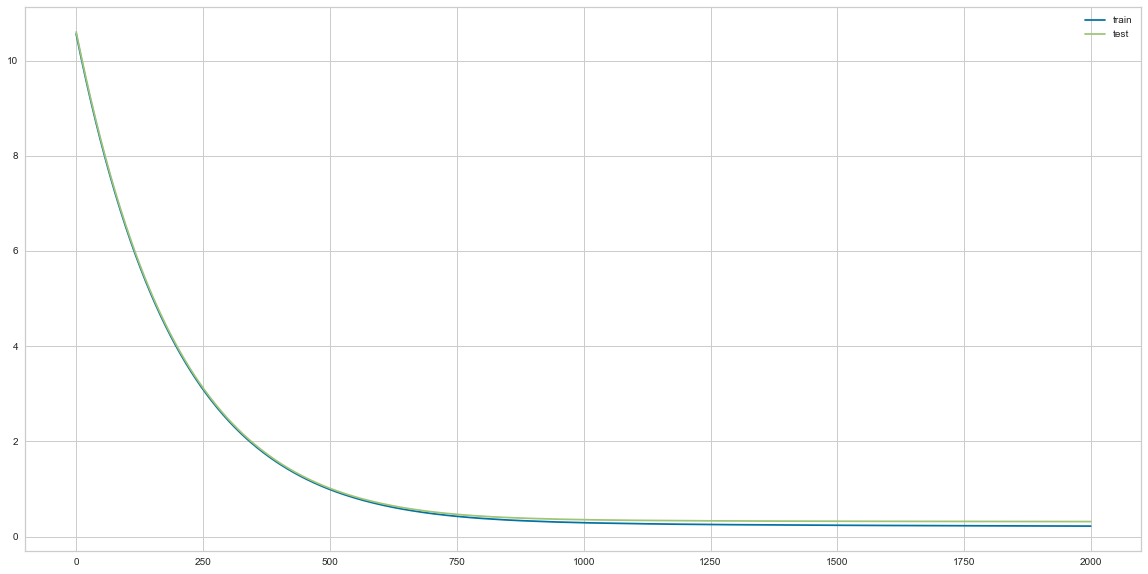

In [78]:
# plot learning curve of an xgboost model

# define the model
model = XGBRegressor(n_estimators=2000, max_depth=10, min_child_weight=5, gamma=0.4, 
                     eval_metric='rmse', eta=0.005, colsample_bytree=0.7, subsample=0.6, n_jobs=-1)
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
model.fit(X_train, y_train, eval_metric='rmse', eval_set=evalset)
# evaluate performance
yhat = model.predict(X_test)
score = mse(y_test, yhat)**0.5
print('RMSE: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()


# plot learning curves
fig = plt.figure(figsize=(20, 10))
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

we can claim that the model doesn't overfit

#### Prediction

In [79]:
# rf prediction
y_rf_pred = rf_model.predict(X_test)
y_rf_pred_train = rf_model.predict(X_train)

# xgb prediction
y_xgb_pred = xgb_model.predict(X_test)
y_xgb_pred_train = xgb_model.predict(X_train)

# cutboost prediction
y_cbt_pred = cbt_model.predict(X_test)
y_cbt_pred_train = cbt_model.predict(X_train)

# lgbm prediction
y_lgbm_pred = lgbm_model.predict(X_test)
y_lgbm_pred_train = lgbm_model.predict(X_train)

In [80]:
y_pred = blender([y_xgb_pred, y_cbt_pred])
y_pred_train = blender([y_xgb_pred_train, y_cbt_pred_train])

In [81]:
print(f"RMSE score for random forest for the testing set: {mse(y_test, y_rf_pred)**0.5}")
print(f"RMSE score for random forest for the training set: {mse(y_train, y_rf_pred_train)**0.5}")
print("----------------------------------------------------------")
print(f"RMSE score for xgboost for the testing set: {mse(y_test, y_xgb_pred)**0.5}")
print(f"RMSE score for xgboost for the training set: {mse(y_train, y_rf_pred_train)**0.5}")
print("----------------------------------------------------------")
print(f"RMSE score for catboost for the testing set: {mse(y_test, y_cbt_pred)**0.5}")
print(f"RMSE score for catboost for the training set: {mse(y_train, y_cbt_pred_train)**0.5}")
print("----------------------------------------------------------")
print(f"RMSE score for lgbm for the testing set: {mse(y_test, y_lgbm_pred)**0.5}")
print(f"RMSE score for lgbm for the training set: {mse(y_train, y_lgbm_pred_train)**0.5}")
print("----------------------------------------------------------")
print(f"RMSE score for blending for the testing set: {mse(y_test, y_pred)**0.5}")
print(f"RMSE score for blending for the training set: {mse(y_train, y_pred_train)**0.5}")
print("----------------------------------------------------------")

RMSE score for random forest for the testing set: 0.4092617433125068
RMSE score for random forest for the training set: 0.1557552571929026
----------------------------------------------------------
RMSE score for xgboost for the testing set: 0.30491666680317897
RMSE score for xgboost for the training set: 0.1557552571929026
----------------------------------------------------------
RMSE score for catboost for the testing set: 0.3160312183830511
RMSE score for catboost for the training set: 0.2292869319557764
----------------------------------------------------------
RMSE score for lgbm for the testing set: 0.5539484723930322
RMSE score for lgbm for the training set: 0.5560950468778139
----------------------------------------------------------
RMSE score for blending for the testing set: 0.3063245280763329
RMSE score for blending for the training set: 0.20912786788814006
----------------------------------------------------------


- the best model is Xgboost in the testing
- Catboost is the best model in terme of overfiting

**we will use xgboost in the submission as final model**

# Submission

In [82]:
y = data.target
X = data.drop(['target', 'flight_date'], axis=1)

In [83]:
X_submission = data_submission.drop(['flight_date'], axis=1)

In [84]:
concatenated = pd.concat([X, X_submission])
concatenated = concatenated.reset_index()
concatenated

,index,from,to,avg_weeks,std_weeks,from_latitude,from_longitude,to_latitude,to_longitude,distance,year,dayofweek,month,day,week,julian,quarter,Average Fare ($),Average Fare ($)_to,Fare
0,0,ORD,DFW,12.875000,9.812647,41.974163,-87.907320,32.899810,-97.040340,1289.698532,2012,1,6,19,25,900,2,392.50,449.76,4.064916
1,1,LAS,DEN,14.285714,9.466734,36.084000,-115.153740,39.856100,-104.673740,1010.700812,2012,0,9,10,37,983,3,261.84,315.72,4.005149
2,2,DEN,LAX,10.863636,9.035883,39.856100,-104.673740,33.941590,-118.408530,1386.808962,2012,4,10,5,40,1008,4,320.95,409.82,4.498364
3,3,ATL,ORD,11.480000,7.990202,33.640728,-84.427704,41.974163,-87.907320,974.145965,2011,6,10,9,40,646,4,378.08,373.97,1.631199
4,4,DEN,SFO,11.450000,9.517159,39.856100,-104.673740,37.621310,-122.378950,1556.562600,2012,1,2,21,8,781,1,320.96,377.89,4.059235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11123,2227,SEA,ORD,10.055556,7.336229,47.450250,-122.308815,41.974163,-87.907320,2768.975320,2013,2,1,30,5,1125,1,373.16,391.19,2.946017
11124,2228,MCO,EWR,15.310345,10.525830,28.431158,-81.308080,40.689533,-74.174460,1507.879751,2013,3,1,3,1,1098,1,289.28,485.79,5.285789
11125,2229,PHL,DFW,8.529412,6.022018,39.874397,-75.242424,32.899810,-97.040340,2096.439155,2013,6,1,13,2,1108,1,401.20,415.82,2.748552
11126,2230,PHL,ATL,9.315789,6.289786,39.874397,-75.242424,33.640728,-84.427704,1071.894569,2012,6,12,23,51,1087,4,387.29,360.76,3.315276


In [85]:
concatenated = pd.get_dummies(concatenated)

In [86]:
X_processed = concatenated.iloc[:X.shape[0], ]
X_submission_processed = concatenated.iloc[X.shape[0]:, ]

In [87]:
final_model = XGBRegressor(n_estimators=4100, max_depth=10, min_child_weight=5, gamma=0.4, 
                           eval_metric='rmse', eta=0.005, colsample_bytree=0.7, subsample=0.6, n_jobs=-1)

In [88]:
final_model.fit(X_processed, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.005,
             eval_metric='rmse', gamma=0.4, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.00499999989,
             max_delta_step=0, max_depth=10, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=4100, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [89]:
y_pred = final_model.predict(X_submission_processed)

In [90]:
print(f"the TRAIN RMSE:{mse(y, final_model.predict(X_processed))**0.5}")

the TRAIN RMSE:0.19072774419953323


In [91]:
submission = pd.DataFrame(y_pred)

In [92]:
""" THIS CELL GENERATES THE SUBMISSION FILE """
# path = f"submission_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
# submission.to_csv(path, index=False, header=False)

' THIS CELL GENERATES THE SUBMISSION FILE '

## Duration of execution

In [93]:
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:22:38.947635
